In [1]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=f5c3706f543c1a1644c832f38a2bf3f34bd93dbc309fbff7e16b1f1c0ce457c2
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



=== META-LEARNING DIAGNOSTIC (Episode ~0) ===
META-LEARNING DIAGNOSTIC ANALYSIS
Testing statistical classification...
Sample 0: pred=0, conf=1.000, true=1
Sample 1: pred=0, conf=1.000, true=1
Sample 2: pred=0, conf=1.000, true=1
Sample 3: pred=0, conf=1.000, true=1
Sample 4: pred=0, conf=1.000, true=1
Sample 5: pred=0, conf=1.000, true=1
Sample 6: pred=0, conf=1.000, true=1
Sample 7: pred=0, conf=1.000, true=1
Sample 8: pred=0, conf=1.000, true=1
Sample 9: pred=0, conf=1.000, true=1
Statistical-only accuracy: 0.000

Testing neural classification...
Sample 0: pred=0, conf=0.502, true=1
Sample 1: pred=0, conf=0.533, true=1
Sample 2: pred=1, conf=0.517, true=1
Sample 3: pred=1, conf=0.503, true=1
Sample 4: pred=0, conf=0.508, true=1
Sample 5: pred=1, conf=0.509, true=1
Sample 6: pred=1, conf=0.522, true=1
Sample 7: pred=1, conf=0.546, true=1
Sample 8: pred=1, conf=0.519, true=1
Sample 9: pred=1, conf=0.523, true=1
Neural-only accuracy: 0.700

Testing current hybrid prediction...
Current 

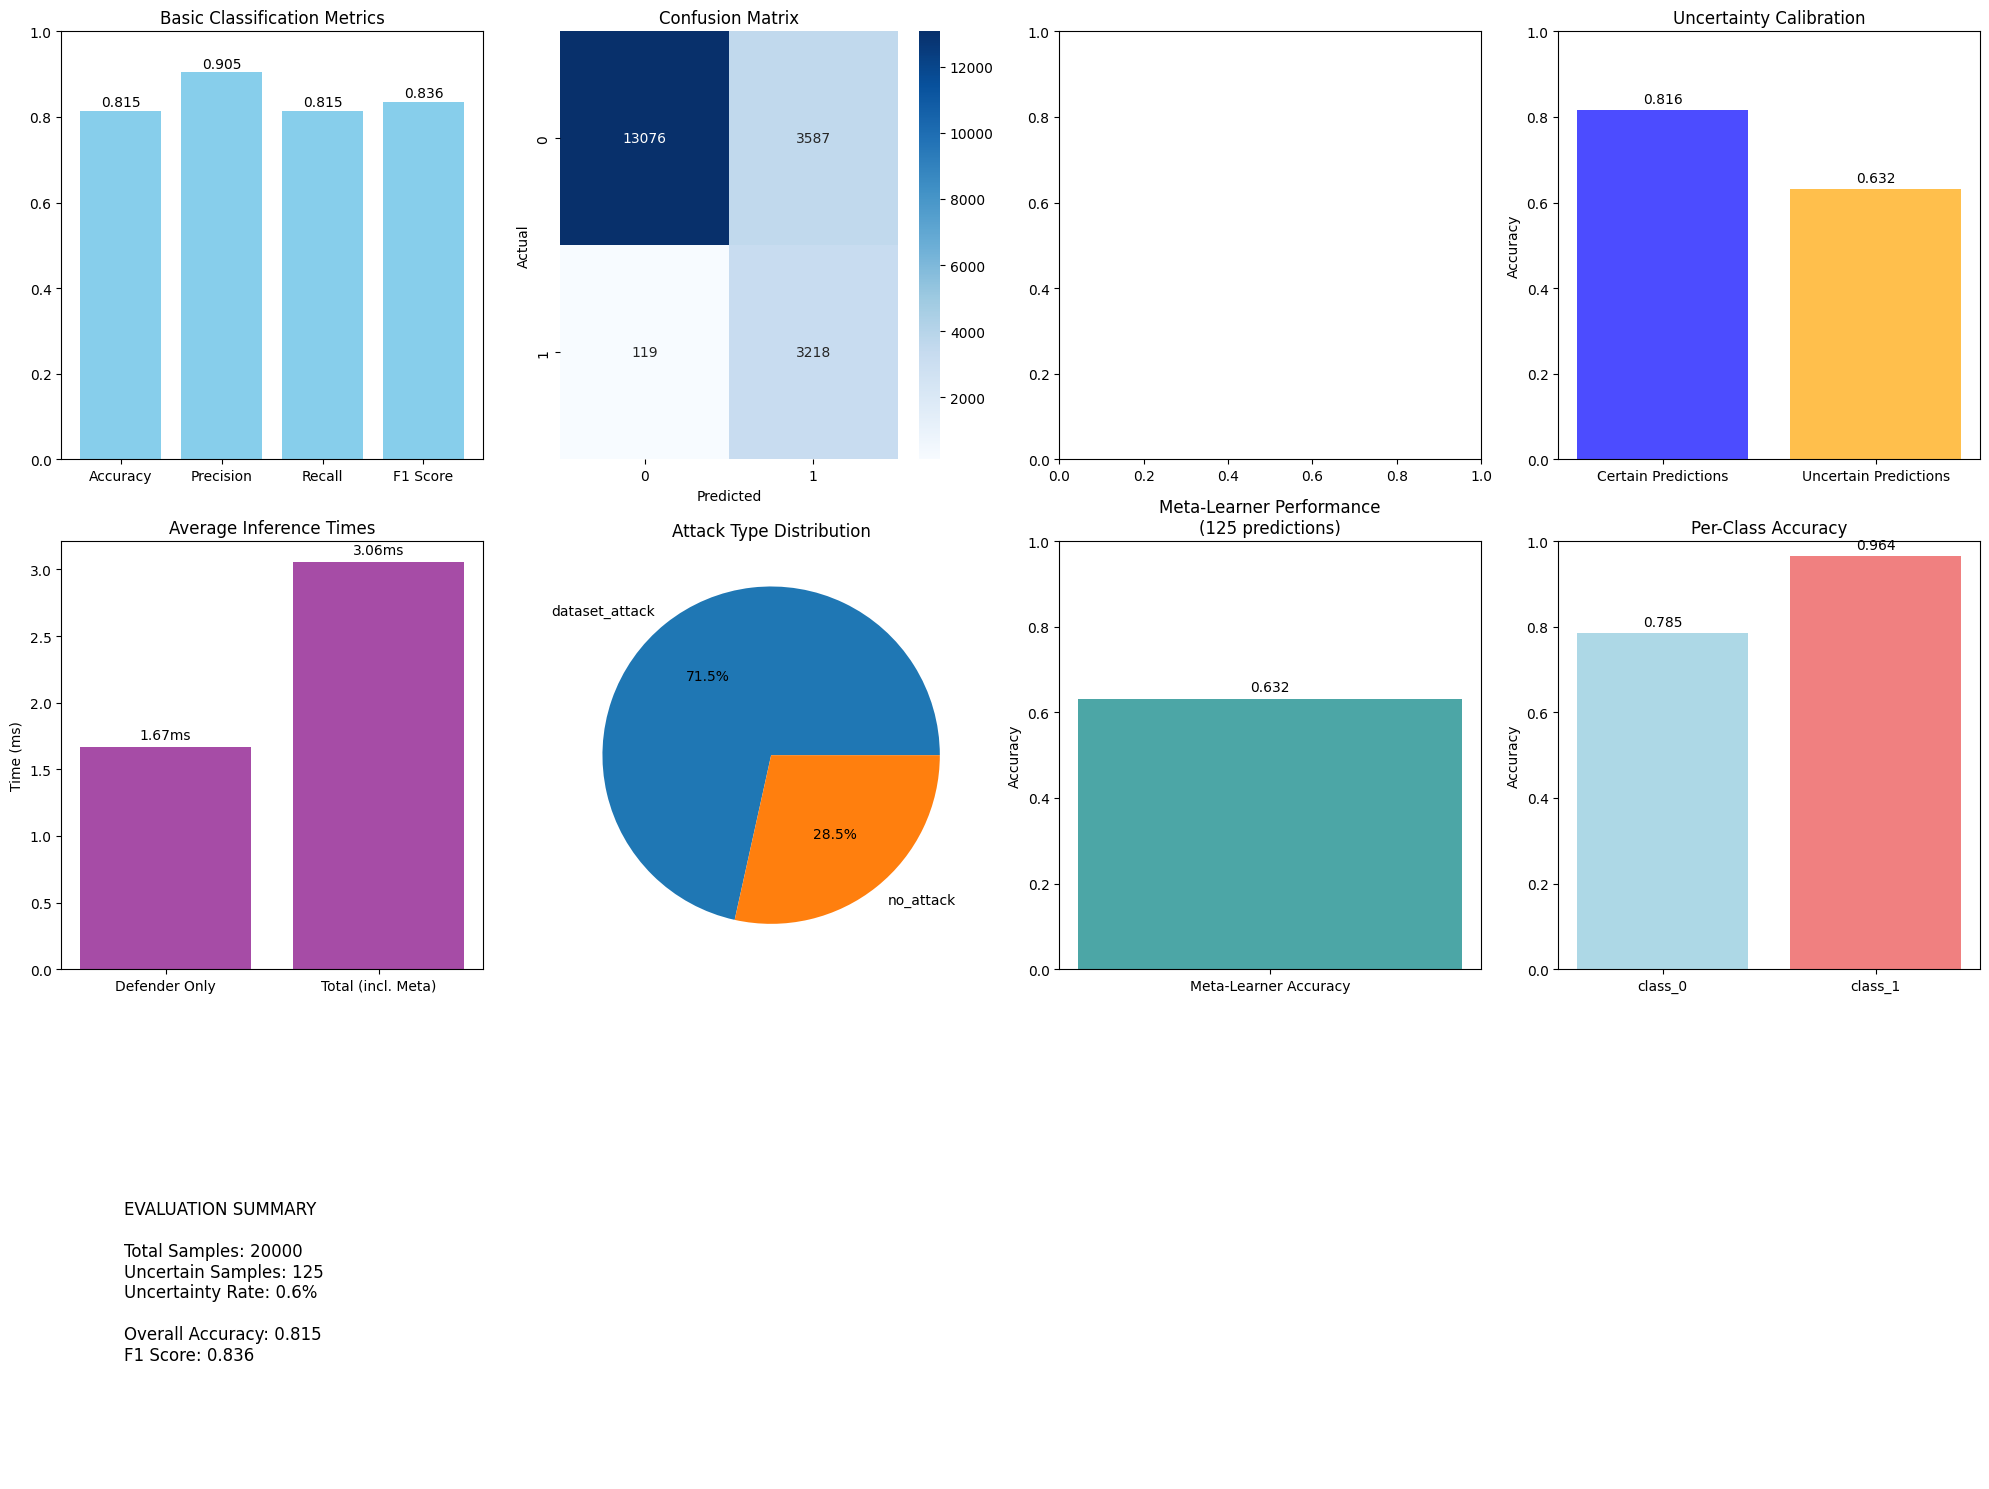


ENHANCED STATISTICAL META-LEARNING ADVERSARIAL NIDS - FINAL REPORT

STATISTICAL META-LEARNING PERFORMANCE:
  Average Statistical-Only Accuracy: 0.5772
  Average Hybrid Accuracy: 0.7547
  Average Improvement: 0.1775
  Statistical Method Reliability: 45.1%

ATTACK PROTOTYPE ANALYSIS:
  Total Attack Prototypes Discovered: 85
  Average Prototype Size: 319.6
  Prototype Distribution: {'adaptive_0': 2400, 'adaptive_1': 9584, 'adaptive_2': 4921, 'adaptive_3': 3565, 'adaptive_4': 1210, 'adaptive_5': 642, 'adaptive_6': 69, 'adaptive_7': 37, 'adaptive_8': 39, 'adaptive_9': 1477, 'adaptive_10': 148, 'adaptive_11': 79, 'adaptive_12': 46, 'adaptive_13': 110, 'adaptive_14': 146, 'adaptive_15': 32, 'adaptive_16': 269, 'adaptive_17': 213, 'adaptive_18': 606, 'adaptive_19': 143, 'adaptive_20': 32, 'adaptive_21': 3, 'adaptive_22': 290, 'adaptive_23': 46, 'adaptive_24': 17, 'adaptive_25': 149, 'adaptive_26': 48, 'adaptive_27': 9, 'adaptive_28': 5, 'adaptive_29': 1, 'adaptive_30': 56, 'adaptive_31': 19, 

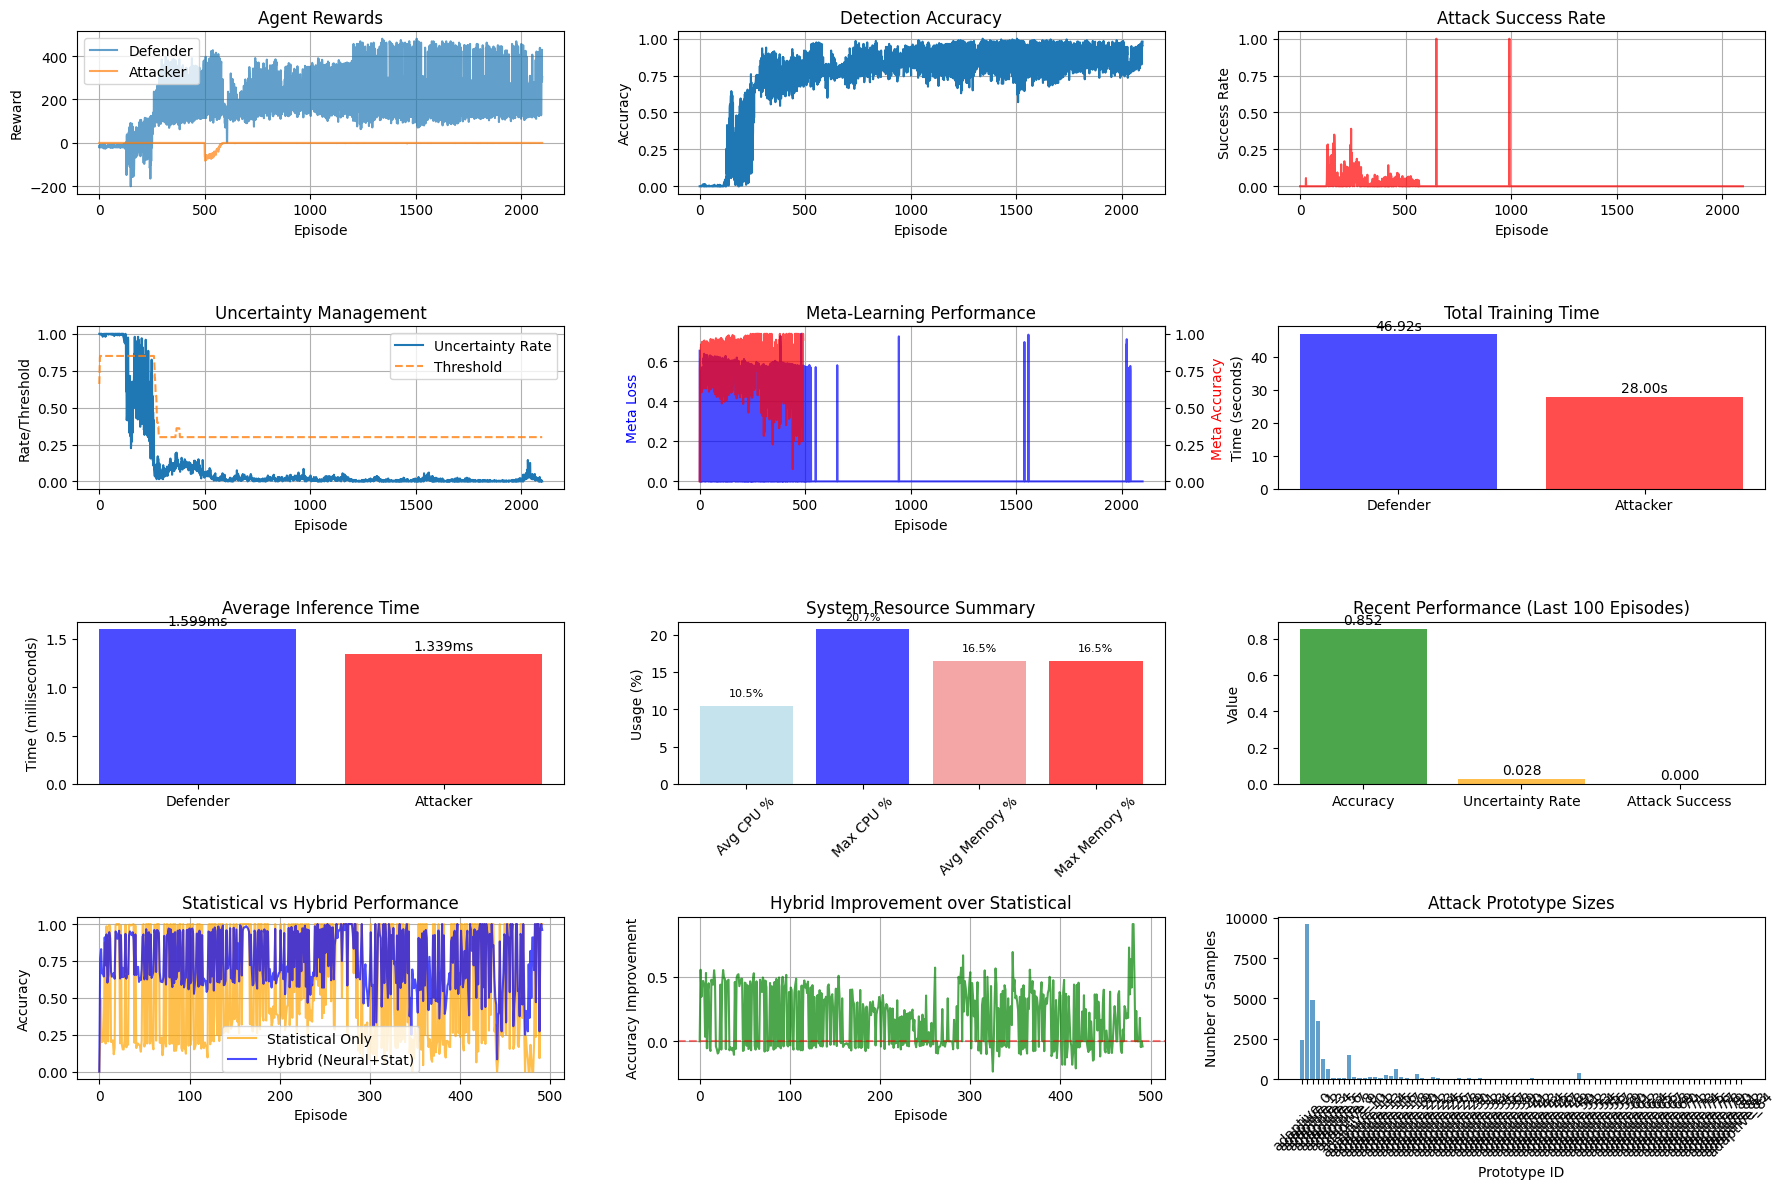

ERROR:__main__:Error loading CICIDS2018: [Errno 2] No such file or directory: '/content/harmonized_2018_dataset.csv'
ERROR:__main__:Error during training: 'NoneType' object is not subscriptable
Traceback (most recent call last):
  File "/tmp/ipython-input-2223298388.py", line 3458, in <cell line: 0>
    cross_dataset_results = evaluate_on_cicids2018(
                            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2223298388.py", line 3032, in evaluate_on_cicids2018
    class_vals, class_counts = np.unique(data_2018['y_2018'], return_counts=True)
                                         ~~~~~~~~~^^^^^^^^^^
TypeError: 'NoneType' object is not subscriptable


In [3]:
# Importing Libraries
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import gym
from gym import spaces
import psutil
import time
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque, defaultdict
import logging
import warnings
import os
import threading
from collections import defaultdict
from sklearn.cluster import KMeans
import GPUtil
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(filename="PipelineLogs.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# ==============================================================================
# SYSTEM MONITORING AND METRICS
# ==============================================================================

class SimpleMetricsTracker:
    """Lightweight system metrics tracker - no background monitoring"""

    def __init__(self):
        self.metrics = {
            'defender': {'training_times': [], 'inference_times': []},
            'attacker': {'training_times': [], 'inference_times': []},
            'system_snapshots': []  # Added few snapshots instead of continuous monitoring
        }
        self.operation_start_time = None

    def start_operation(self, agent_type, operation_type):
        """Simply record start time"""
        self.current_agent = agent_type
        self.current_operation = operation_type
        self.operation_start_time = time.time()

    def end_operation(self):
        """Record operation duration and optionally take a system snapshot"""
        if self.operation_start_time is None:
            return

        duration = time.time() - self.operation_start_time

        # Record timing
        if hasattr(self, 'current_agent') and hasattr(self, 'current_operation'):
            key = f"{self.current_operation}_times"
            if key in self.metrics[self.current_agent]:
                self.metrics[self.current_agent][key].append(duration)

        # Occasionally take system snapshots (every 100th operation)
        if len(self.metrics['system_snapshots']) < 50 and duration > 0.01:  # Limit snapshots
            try:
                snapshot = {
                    'cpu': psutil.cpu_percent(),
                    'memory': psutil.virtual_memory().percent,
                    'agent': getattr(self, 'current_agent', 'unknown'),
                    'operation': getattr(self, 'current_operation', 'unknown')
                }
                self.metrics['system_snapshots'].append(snapshot)
            except:
                pass  # Ignore errors

        self.operation_start_time = None

    def get_summary(self):
        """Get simple metrics summary"""
        summary = {}

        for agent in ['defender', 'attacker']:
            if agent in self.metrics:
                agent_metrics = self.metrics[agent]
                summary[agent] = {
                    'training': {
                        'total_time': sum(agent_metrics['training_times']),
                        'avg_time': sum(agent_metrics['training_times']) / max(1, len(agent_metrics['training_times'])),
                        'count': len(agent_metrics['training_times'])
                    },
                    'inference': {
                        'total_time': sum(agent_metrics['inference_times']),
                        'avg_time': sum(agent_metrics['inference_times']) / max(1, len(agent_metrics['inference_times'])),
                        'count': len(agent_metrics['inference_times'])
                    }
                }

        # Simple system stats from snapshots
        if self.metrics['system_snapshots']:
            snapshots = self.metrics['system_snapshots']
            summary['system'] = {
                'avg_cpu': sum(s['cpu'] for s in snapshots) / len(snapshots),
                'max_cpu': max(s['cpu'] for s in snapshots),
                'avg_memory': sum(s['memory'] for s in snapshots) / len(snapshots),
                'max_memory': max(s['memory'] for s in snapshots),
                'snapshots_taken': len(snapshots)
            }

        return summary

# Simple context manager
class MetricsContext:
    def __init__(self, tracker, agent_type, operation_type):
        self.tracker = tracker
        self.agent_type = agent_type
        self.operation_type = operation_type

    def __enter__(self):
        self.tracker.start_operation(self.agent_type, self.operation_type)
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.tracker.end_operation()


# ==============================================================================
# ATTACK GENERATION AND ADVERSARIAL COMPONENTS
# ==============================================================================

class AttackGenerator:
    """Generate various types of attacks for adversarial training"""

    def __init__(self, feature_ranges=None):
        self.feature_ranges = feature_ranges
        self.attack_patterns = {
            'evasion': self._evasion_attack,
            'mimicry': self._mimicry_attack,
            'noise': self._noise_attack
        }

    def generate_attack(self, original_sample, attack_type='evasion', intensity=0.1):
        """Generate attacked version of sample"""
        if attack_type not in self.attack_patterns:
            return original_sample

        return self.attack_patterns[attack_type](original_sample, intensity)

    def _evasion_attack(self, sample, intensity=0.1):
        """Simple evasion attack - add noise to features"""
        noise = np.random.normal(0, intensity, size=sample.shape)
        attacked_sample = sample + noise
        return attacked_sample

    def _mimicry_attack(self, sample, intensity=0.1):
        """Mimicry attack - make malicious traffic look benign"""
        # Reduce values in key features that indicate malicious activity
        attacked_sample = sample.copy()
        # Assume first 10 features are most discriminative
        attacked_sample[:10] *= (1 - intensity)
        return attacked_sample

    def _noise_attack(self, sample, intensity=0.1):
        """Add random noise"""
        noise = np.random.uniform(-intensity, intensity, size=sample.shape)
        return sample + noise

# ==============================================================================
# REINFORCEMENT LEARNING ENVIRONMENT
# ==============================================================================

class EnhancedNetworkEnvironment:
    """Enhanced Network Environment with both Defender and Attacker Actions"""

    def __init__(self, X_data, y_data, max_steps=1000):
        self.X_data_original = X_data.copy()
        self.y_data = y_data
        self.max_steps = max_steps
        self.current_step = 0
        self.current_idx = 0
        self.data_size = len(X_data)

        # Initialize attack generator
        self.attack_generator = AttackGenerator()

        # Current state of data
        self.X_data_current = X_data.copy()
        self.current_sample_attacked = False

        # Action spaces
        # Defender: 0=benign, 1=malicious, 2=uncertain
        self.defender_action_space = spaces.Discrete(3)
        # Attacker: 0=no_attack, 1=dataset_attack, 2=evasion_attack, 3=mimicry_attack
        self.attacker_action_space = spaces.Discrete(4)

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(X_data.shape[1],))

        # Metrics tracking
        self.detection_results = {'correct': 0, 'incorrect': 0, 'uncertain': 0}
        self.attack_results = {'no_attack': 0, 'dataset_attack': 0, 'evasion_attack': 0, 'mimicry_attack': 0}
        self.uncertain_samples = {'X': [], 'y_true': [], 'was_attacked': []}

        # Attack success tracking
        self.successful_attacks = 0
        self.total_attacks = 0

        # Add phase tracking for reward scaling
        self.current_phase = 1
        self.phase_episodes = 0

    def reset(self):
        """Reset environment"""
        self.current_step = 0
        self.current_idx = np.random.randint(0, self.data_size)
        self.detection_results = {'correct': 0, 'incorrect': 0, 'uncertain': 0}
        self.attack_results = {'no_attack': 0, 'dataset_attack': 0, 'evasion_attack': 0, 'mimicry_attack': 0}
        self.uncertain_samples = {'X': [], 'y_true': [], 'was_attacked': []}
        self.successful_attacks = 0
        self.total_attacks = 0

        # Reset data to original state
        self.X_data_current = self.X_data_original.copy()
        self.current_sample_attacked = False

        return self.get_current_observation()

    def get_current_observation(self):
        """Get current network flow observation"""
        return self.X_data_current[self.current_idx]

    def step(self, defender_action, attacker_action=None):
        """Execute both defender and attacker actions"""
        # Get original sample
        original_obs = self.X_data_original[self.current_idx]
        true_label = self.y_data[self.current_idx]

        # Apply attacker action first
        if attacker_action is not None:
            current_obs = self._apply_attacker_action(original_obs, attacker_action, true_label)
        else:
            current_obs = original_obs
            attacker_action = 0  # No attack

        # Update current data
        self.X_data_current[self.current_idx] = current_obs

        # Calculate rewards
        defender_reward = self._calculate_defender_reward(defender_action, true_label, attacker_action)
        attacker_reward = self._calculate_attacker_reward(defender_action, attacker_action, true_label)

        # Update metrics
        self._update_metrics(defender_action, attacker_action, true_label, current_obs)

        # Move to next sample
        self.current_step += 1
        self.current_idx = (self.current_idx + 1) % self.data_size

        done = self.current_step >= self.max_steps
        next_obs = self.get_current_observation() if not done else current_obs

        info = self.get_info()

        return next_obs, defender_reward, attacker_reward, done, info

    def _apply_attacker_action(self, original_sample, attacker_action, true_label):
        """Apply attacker action to modify the sample"""
        self.attack_results[list(self.attack_results.keys())[attacker_action]] += 1

        # No attack
        if attacker_action == 0:
            return original_sample
        # Dataset attack (use as-is)
        elif attacker_action == 1:
            return original_sample
        # Evasion attack
        elif attacker_action == 2:
            self.total_attacks += 1
            self.current_sample_attacked = True
            return self.attack_generator.generate_attack(original_sample, 'evasion', 0.1)
        # Mimicry attack
        elif attacker_action == 3:
            self.total_attacks += 1
            self.current_sample_attacked = True
            return self.attack_generator.generate_attack(original_sample, 'mimicry', 0.15)
        else:
            return original_sample

    def _calculate_defender_reward(self, defender_action, true_label, attacker_action):
        """Calculate defender reward"""
        base_reward = 0

        if defender_action == true_label:
            # Correctly identified malicious
            if true_label == 1:
                base_reward = 2.0
            # Correctly identified benign
            else:
                base_reward = 1.0

            # Bonus for detecting attacks
            if attacker_action > 1 and true_label == 1:
                base_reward += 0.5

        # Uncertain
        elif defender_action == 2:
            if true_label == 1:  # Being uncertain about malicious is better than missing it
                base_reward = -0.1
            else:
                base_reward = -0.05

        # Wrong classification
        else:
            if true_label == 1:  # Missing malicious traffic is very bad
                base_reward = -3.0
            else:  # False positive
                base_reward = -1.0

        return base_reward

    def _calculate_attacker_reward(self, defender_action, attacker_action, true_label):
        """Calculate attacker reward"""
        # No attack or dataset attack
        if attacker_action <= 1:
            return 0.0

        # Malicious sample
        if true_label == 1:
            # Misclassified as benign
            if defender_action == 0:
                self.successful_attacks += 1
                # High reward for successful evasion
                return 0.4
            # Made defender uncertain
            elif defender_action == 2:
                # Moderate reward for creating uncertainty
                return 0.1
            # Defender correctly identified
            else:
                # Penalty for failed attack
                return -0.8
        # Benign sample
        else:
            # Attacker shouldn't attack benign samples heavily
            return -0.6

    def _update_metrics(self, defender_action, attacker_action, true_label, current_obs):
        """Update tracking metrics"""
        # Defender metrics
        if defender_action == 2:
            self.detection_results['uncertain'] += 1
            self.uncertain_samples['X'].append(current_obs)
            self.uncertain_samples['y_true'].append(true_label)
            self.uncertain_samples['was_attacked'].append(self.current_sample_attacked)
        elif defender_action == true_label:
            self.detection_results['correct'] += 1
        else:
            self.detection_results['incorrect'] += 1

    def get_info(self):
        """Get environment information"""
        total_samples = sum(self.detection_results.values())
        if total_samples > 0:
            accuracy = self.detection_results['correct'] / total_samples
            uncertainty_rate = self.detection_results['uncertain'] / total_samples
        else:
            accuracy = 0
            uncertainty_rate = 0

        attack_success_rate = (self.successful_attacks / max(1, self.total_attacks)) if self.total_attacks > 0 else 0

        return {
            'accuracy': accuracy,
            'uncertainty_rate': uncertainty_rate,
            'total_samples': total_samples,
            'uncertain_count': len(self.uncertain_samples['X']),
            'attack_success_rate': attack_success_rate,
            'total_attacks': self.total_attacks,
            'successful_attacks': self.successful_attacks,
            'attack_distribution': self.attack_results.copy()
        }

# ==============================================================================
# PPO Agent
# ==============================================================================

class FixedPPOAgent:
    """PPO Agent with proper uncertainty calibration"""

    def __init__(self, input_dim, action_dim, lr=3e-4, gamma=0.99, eps_clip=0.2,
                 uncertainty_threshold=0.6, device='cpu', agent_type='defender', metrics_tracker=None):
        self.device = device
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.uncertainty_threshold = uncertainty_threshold
        self.agent_type = agent_type
        self.metrics_tracker=metrics_tracker

        # Use different network architectures for defender vs attacker
        if agent_type == 'defender':
            self.policy = DefenderNetwork(input_dim, action_dim).to(device)
        else:
            self.policy = AttackerNetwork(input_dim, action_dim).to(device)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        # Storage for trajectory
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.uncertainties = []
        self.dones = []

        # Meta-learning integration (only for defender)
        if agent_type == 'defender':
            self.meta_feedback_buffer = deque(maxlen=1000)

        # Performance tracking
        self.episode_rewards = []
        self.success_rate = deque(maxlen=100)

    def select_action(self, state, use_uncertainty=True):
        """Select action with improved uncertainty logic"""
        # Start monitoring if metrics tracker is available
        if self.metrics_tracker:
            self.metrics_tracker.start_operation(self.agent_type, 'inference')
        try:
            return self._select_action_impl(state, use_uncertainty)
        finally:
            if self.metrics_tracker:
              self.metrics_tracker.end_operation()

    def _select_action_impl(self, state, use_uncertainty=True):
        """Implementation of select_action without metrics tracking"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

            if self.agent_type == 'defender' and use_uncertainty:
                # Defender with uncertainty estimation
                action_probs, value, uncertainty = self.policy(state_tensor)

                # Calculate confidence metrics
                max_prob = torch.max(action_probs).item()
                entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8)).item()

                # More balanced uncertainty decision
                confidence_score = max_prob - entropy * 0.2
                uncertainty_score = uncertainty.item()

                # Decision logic: be more decisive
                if (max_prob < 0.65 and uncertainty_score > self.uncertainty_threshold) or entropy > 1.0:
                    # Only be uncertain if really unsure AND it makes sense
                    if max_prob < 0.55:  # Very uncertain
                        action = 2
                        final_uncertainty = uncertainty_score
                    else:
                        # Make a decision anyway
                        dist = Categorical(action_probs)
                        action = dist.sample()
                        final_uncertainty = uncertainty_score * 0.3
                else:
                    # Make confident decision
                    dist = Categorical(action_probs)
                    action = dist.sample()
                    final_uncertainty = uncertainty_score * 0.1

            else:
                # Standard action selection
                if self.agent_type == 'defender':
                    action_probs, value, uncertainty = self.policy(state_tensor)
                    final_uncertainty = uncertainty.item()
                else:
                    action_probs, value = self.policy(state_tensor)
                    final_uncertainty = 0.0

                dist = Categorical(action_probs)
                action = dist.sample()

            # Calculate log probability
            dist = Categorical(action_probs)
            if isinstance(action, int):
                action_tensor = torch.tensor([action]).to(self.device)
            else:
                action_tensor = action
            log_prob = dist.log_prob(action_tensor)

            final_action = action.item() if hasattr(action, 'item') else action

        return final_action, log_prob.item(), value.item(), final_uncertainty

    def store_transition(self, state, action, reward, log_prob, value, uncertainty, done):
        """Store transition"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.uncertainties.append(uncertainty)
        self.dones.append(done)

    def compute_returns(self):
        """Compute returns with improved reward shaping"""
        returns = []
        discounted_sum = 0

        for reward, done in zip(reversed(self.rewards), reversed(self.dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)

        return returns

    def update(self):
        """Enhanced PPO update with better tensor handling"""
        if len(self.states) == 0:
            return {}

        # Use context manager only if metrics tracker exists
        if self.metrics_tracker:
            self.metrics_tracker.start_operation(self.agent_type, 'training')

        try:
            # Convert to tensors with proper error handling
            states = torch.FloatTensor(np.array(self.states)).to(self.device)
            actions = torch.LongTensor(self.actions).to(self.device)
            old_log_probs = torch.FloatTensor(self.log_probs).to(self.device)
            returns = torch.FloatTensor(self.compute_returns()).to(self.device)
            old_values = torch.FloatTensor(self.values).to(self.device)
            old_uncertainties = torch.FloatTensor(self.uncertainties).to(self.device)

            # Ensure all tensors have the same batch size
            batch_size = min(len(states), len(actions), len(old_log_probs),
                            len(returns), len(old_values), len(old_uncertainties))

            states = states[:batch_size]
            actions = actions[:batch_size]
            old_log_probs = old_log_probs[:batch_size]
            returns = returns[:batch_size]
            old_values = old_values[:batch_size]
            old_uncertainties = old_uncertainties[:batch_size]

            # Normalize returns
            if batch_size > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Calculate advantages
            advantages = returns - old_values
            if batch_size > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # PPO update
            total_policy_loss = 0
            total_value_loss = 0
            total_uncertainty_loss = 0

            for epoch in range(4):
                # Get current policy outputs
                if self.agent_type == 'defender':
                    action_probs, values, uncertainty_preds = self.policy(states)
                    uncertainty_preds = uncertainty_preds.squeeze()
                else:
                    action_probs, values = self.policy(states)
                    uncertainty_preds = torch.zeros_like(values)

                values = values.squeeze()

                # Handle dimension issues
                if values.dim() == 0:
                    values = values.unsqueeze(0)
                if uncertainty_preds.dim() == 0:
                    uncertainty_preds = uncertainty_preds.unsqueeze(0)

                # Ensure correct batch size
                values = values[:batch_size]
                uncertainty_preds = uncertainty_preds[:batch_size]

                dist = Categorical(action_probs)
                new_log_probs = dist.log_prob(actions)
                entropy = dist.entropy().mean()

                # Calculate ratio
                ratio = torch.exp(new_log_probs - old_log_probs)

                # PPO losses
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value loss
                value_loss = nn.MSELoss()(values, returns)

                # Uncertainty loss (only for defender)
                uncertainty_loss = 0
                if self.agent_type == 'defender':
                    # Be uncertain when uncertainty score is high
                    uncertainty_targets = (old_uncertainties > self.uncertainty_threshold).float()
                    uncertainty_targets = uncertainty_targets[:batch_size]
                    uncertainty_loss = nn.BCELoss()(uncertainty_preds, uncertainty_targets)

                # Total loss
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                if self.agent_type == 'defender':
                    loss += 0.1 * uncertainty_loss

                # Update
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                self.optimizer.step()

                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
                if self.agent_type == 'defender':
                    total_uncertainty_loss += uncertainty_loss.item() if isinstance(uncertainty_loss, torch.Tensor) else uncertainty_loss

            # Clear storage
            self.clear_trajectory()

            return {
                'policy_loss': total_policy_loss / 4,
                'value_loss': total_value_loss / 4,
                'uncertainty_loss': total_uncertainty_loss / 4 if self.agent_type == 'defender' else 0,
                'entropy': entropy.item()
            }

        finally:
          if self.metrics_tracker:
              self.metrics_tracker.end_operation()

    def clear_trajectory(self):
        """Clear stored trajectory"""
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.log_probs.clear()
        self.values.clear()
        self.uncertainties.clear()
        self.dones.clear()

    def update_uncertainty_threshold(self, new_threshold):
        """Update uncertainty threshold"""
        self.uncertainty_threshold = max(0.1, min(0.9, new_threshold))

# ==============================================================================
# NEURAL NETWORK ARCHITECTURES
# ==============================================================================

class DefenderNetwork(nn.Module):
    """Defender network with uncertainty estimation"""
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(DefenderNetwork, self).__init__()

        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Actor head
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic head
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

        # Uncertainty estimation head
        self.uncertainty = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        shared_features = self.shared(x)
        action_probs = self.actor(shared_features)
        state_value = self.critic(shared_features)
        uncertainty_score = self.uncertainty(shared_features)
        return action_probs, state_value, uncertainty_score

class AttackerNetwork(nn.Module):
    """Attacker network without uncertainty estimation"""
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(AttackerNetwork, self).__init__()

        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor head
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic head
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, x):
        shared_features = self.shared(x)
        action_probs = self.actor(shared_features)
        state_value = self.critic(shared_features)
        return action_probs, state_value

# ==============================================================================
# DATA PREPROCESSING
# ==============================================================================

class ImprovedDataPreprocessor:
    """Enhanced data preprocessor with better error handling"""
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None

    def load_and_preprocess(self, data_path, test_size=0.2, val_size=0.1):
        """Enhanced data loading with better error handling"""
        try:
            logger.info("Loading CIC-IDS2017 dataset...")

            if not os.path.exists(data_path):
                logger.warning(f"Dataset file not found: {data_path}")
                logger.info("Creating dummy dataset for testing...")
                return self._create_dummy_dataset()

            df = pd.read_csv(data_path)
            logger.info(f"Loaded dataset with shape: {df.shape}")

            df = df.drop(['Fwd Header Length.1'], axis=1)

            # Check for required columns
            required_cols = ['Target', 'Label']
            if not any(col in df.columns for col in required_cols):
                logger.warning("No Target or Label columns found, assuming last column is target")
                df['Target'] = df.iloc[:, -1]

            df.reset_index(drop=True, inplace=True)

            # Prepare features and targets
            if 'Target' in df.columns:
                target_col = 'Target'
            elif 'Label' in df.columns:
                target_col = 'Label'
            else:
                target_col = df.columns[-1]
                df['Target'] = df[target_col]

            feature_cols = [col for col in df.columns if col not in ['Target', 'Label']]
            X = df[feature_cols]
            y = df['Target'].values

            # Ensure binary classification
            unique_labels = np.unique(y)
            if len(unique_labels) > 2:
                y = (y > 0).astype(int)

            self.feature_names = X.columns.tolist()

            # Split data
            X_trainval, X_test, y_trainval, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y, shuffle=True)

            X_train, X_val, y_train, y_val = train_test_split(
                X_trainval, y_trainval, test_size=0.25, random_state=42,
                stratify=y_trainval, shuffle=True)

            sm = SMOTE(random_state=42)
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

            # Scale features
            X_train_scaled = self.scaler.fit_transform(X_train_res)
            X_val_scaled = self.scaler.transform(X_val)
            X_test_scaled = self.scaler.transform(X_test)

            logger.info(f"Training set shape: {X_train_scaled.shape}")
            logger.info(f"Validation set shape: {X_val_scaled.shape}")
            logger.info(f"Test set shape: {X_test_scaled.shape}")
            logger.info(f"Class distribution - Train: {np.bincount(y_train_res)}")

            return {
                'X_train': X_train_scaled,
                'y_train': y_train_res,
                'X_val': X_val_scaled,
                'y_val': y_val,
                'X_test': X_test_scaled,
                'y_test': y_test,
                'feature_names': self.feature_names,
                'n_features': X_train_scaled.shape[1]
            }

        except Exception as e:
            logger.error(f"Error loading dataset: {str(e)}")
            logger.info("Creating dummy dataset for testing...")
            return self._create_dummy_dataset()

    def load_and_preprocess_cicids2018(self, data_path_2018, sample_size=100000):
        """Load and preprocess CICIDS2018 dataset to match CICIDS2017 format"""

        logger.info("Loading CICIDS2018 dataset...")

        try:
            df_2018 = pd.read_csv(data_path_2018)
            logger.info(f"Loaded CICIDS2018 with shape: {df_2018.shape}")

            # Sample the data if it's too large
            if len(df_2018) > sample_size:
                # Stratified sampling to maintain class distribution
                from sklearn.model_selection import train_test_split
                df_2018, _ = train_test_split(
                    df_2018,
                    train_size=sample_size,
                    stratify=df_2018['Target'],
                    random_state=42
                )

            # Extract features (exclude label columns)
            feature_cols = [col for col in df_2018.columns if col not in ['Label', 'Target']]
            X_2018 = df_2018[feature_cols]
            y_2018 = df_2018['Target'].values


            # Scale features using the same scaler from CICIDS2017
            if self.scaler is not None:
                X_2018_scaled = self.scaler.transform(X_2018)
            else:
                logger.warning("No scaler provided, using unscaled features")
                X_2018_scaled = X_2018.values

            logger.info(f"Preprocessed CICIDS2018 - Shape: {X_2018_scaled.shape}")
            logger.info(f"Class distribution: {np.bincount(y_2018)}")

            return {
                'X_2018': X_2018_scaled,
                'y_2018': y_2018,
                'feature_names': X_2018.columns.tolist(),
                'n_features': X_2018_scaled.shape[1],
                'n_samples': len(y_2018),
                'class_distribution': dict(zip(*np.unique(y_2018, return_counts=True)))
            }

        except Exception as e:
            logger.error(f"Error loading CICIDS2018: {str(e)}")

# ==============================================================================
# MAIN ADVERSARIAL NIDS SYSTEM
# ==============================================================================

class EnhancedAdversarialNIDS:
    """Enhanced Adversarial NIDS with proper defender-attacker dynamics"""

    def __init__(self, n_features, device='cpu', training_data=None):
        self.device = device
        self.n_features = n_features

        # Initialize system metrics tracker
        self.metrics_tracker = SimpleMetricsTracker()

        # Initialize agents
        self.defender = FixedPPOAgent(n_features, 3, device=device, agent_type='defender', metrics_tracker=self.metrics_tracker)
        self.attacker = None  # Initialized in phase 2

        # Meta-learner for uncertain samples
        self.meta_learner = MetaLearner(n_features, device=device)

        # Initialize with training data if provided
        if training_data is not None:
            self.meta_learner.initialize_with_training_data(
                training_data['X_train'],
                training_data['y_train']
            )


        # Training history
        self.training_history = {
            'defender_rewards': [],
            'attacker_rewards': [],
            'accuracy': [],
            'uncertainty_rate': [],
            'attack_success_rate': [],
            'meta_learning_loss': [],
            'uncertainty_thresholds': [],
            'meta_accuracy': [],
            'statistical_accuracy': [],
            'hybrid_improvement': [],
            'prototype_similarities': [],  # Add this
            'adaptation_quality': []
        }

        # Current phase
        self.current_phase = 1
        self.uncertainty_manager = ImprovedAdaptiveUncertaintyManager()

    def phase_1_training(self, env, episodes=1000):
        """Phase 1: RL Defender vs Scripted Attacker"""
        logger.info("Starting Phase 1: RL Defender vs Scripted Attacker")

        for episode in range(episodes):
            state = env.reset()
            episode_defender_reward = 0
            done = False
            step_count = 0

            while not done and step_count < 200:  # Limit steps per episode
                # Defender selects action
                defender_action, def_log_prob, def_value, def_uncertainty = self.defender.select_action(state)

                # Scripted attacker: simple strategy
                attacker_action = self._scripted_attacker_strategy(state, episode)

                # Environment step
                next_state, defender_reward, attacker_reward, done, info = env.step(defender_action, attacker_action)

                # Store defender transition
                self.defender.store_transition(state, defender_action, defender_reward,
                                             def_log_prob, def_value, def_uncertainty, done)

                state = next_state
                episode_defender_reward += defender_reward
                step_count += 1

            # Update defender policy
            defender_update = self.defender.update()

            # Handle uncertain samples with meta-learning
            if len(env.uncertain_samples['X']) > 10:
                meta_loss = self._handle_uncertain_samples(env.uncertain_samples)
                self.training_history['meta_learning_loss'].append(meta_loss)
            else:
                self.training_history['meta_learning_loss'].append(0)

            # Record metrics
            self.training_history['defender_rewards'].append(episode_defender_reward)
            self.training_history['attacker_rewards'].append(0)  # No learning attacker yet
            self.training_history['accuracy'].append(info.get('accuracy', 0))
            self.training_history['uncertainty_rate'].append(info.get('uncertainty_rate', 0))
            self.training_history['attack_success_rate'].append(info.get('attack_success_rate', 0))

            # Update uncertainty threshold
            uncertainty_rate = info.get('uncertainty_rate', 0)
            if hasattr(self, 'uncertainty_manager'):
                new_threshold = self.uncertainty_manager.update_threshold(uncertainty_rate, 0.9)
                self.defender.update_uncertainty_threshold(new_threshold)
                self.training_history['uncertainty_thresholds'].append(new_threshold)

            if episode % 100 == 0:
                logger.info(f"Episode {episode}, Defender Reward: {episode_defender_reward:.2f}, "
                          f"Accuracy: {info.get('accuracy', 0):.3f}, "
                          f"Uncertainty Rate: {info.get('uncertainty_rate', 0):.3f}, "
                          f"Attack Success: {info.get('attack_success_rate', 0):.3f}")

    def phase_2_training(self, env, episodes=1000):
        """Phase 2: RL Defender vs RL Attacker"""
        logger.info("Starting Phase 2: RL Defender vs RL Attacker")

        # Initialize learning attacker
        self.attacker = FixedPPOAgent(self.n_features, 4, device=self.device, agent_type='attacker', metrics_tracker=self.metrics_tracker)

        for episode in range(episodes):
            state = env.reset()
            episode_defender_reward = 0
            episode_attacker_reward = 0
            done = False
            step_count = 0

            while not done and step_count < 200:
                # Both agents select actions
                defender_action, def_log_prob, def_value, def_uncertainty = self.defender.select_action(state)
                attacker_action, att_log_prob, att_value, att_uncertainty = self.attacker.select_action(state, use_uncertainty=False)

                # Environment step
                next_state, defender_reward, attacker_reward, done, info = env.step(defender_action, attacker_action)

                # Store transitions
                self.defender.store_transition(state, defender_action, defender_reward,
                                             def_log_prob, def_value, def_uncertainty, done)
                self.attacker.store_transition(state, attacker_action, attacker_reward,
                                             att_log_prob, att_value, att_uncertainty, done)

                state = next_state
                episode_defender_reward += defender_reward
                episode_attacker_reward += attacker_reward
                step_count += 1

            # Update both policies
            defender_update = self.defender.update()
            attacker_update = self.attacker.update()

            # Handle uncertain samples
            if len(env.uncertain_samples['X']) > 10:
                meta_loss = self._handle_uncertain_samples(env.uncertain_samples)
                self.training_history['meta_learning_loss'].append(meta_loss)
            else:
                self.training_history['meta_learning_loss'].append(0)

            # Record metrics
            self.training_history['defender_rewards'].append(episode_defender_reward)
            self.training_history['attacker_rewards'].append(episode_attacker_reward)
            self.training_history['accuracy'].append(info.get('accuracy', 0))
            self.training_history['uncertainty_rate'].append(info.get('uncertainty_rate', 0))
            self.training_history['attack_success_rate'].append(info.get('attack_success_rate', 0))

            # Update uncertainty management
            uncertainty_rate = info.get('uncertainty_rate', 0)
            if hasattr(self, 'uncertainty_manager'):
                new_threshold = self.uncertainty_manager.update_threshold(uncertainty_rate, 0.9)
                self.defender.update_uncertainty_threshold(new_threshold)
                self.training_history['uncertainty_thresholds'].append(new_threshold)

            if episode % 100 == 0:
                logger.info(f"Episode {episode}, Def Reward: {episode_defender_reward:.2f}, "
                          f"Att Reward: {episode_attacker_reward:.2f}, "
                          f"Accuracy: {info.get('accuracy', 0):.3f}, "
                          f"Attack Success: {info.get('attack_success_rate', 0):.3f}")

    def phase_3_training(self, env, episodes=1000):
        """Phase 3: Advanced Adversarial Training"""
        logger.info("Starting Phase 3: Advanced Adversarial Training")

        # Use alternating training for better adversarial dynamics
        for episode in range(episodes):
            state = env.reset()
            episode_defender_reward = 0
            episode_attacker_reward = 0
            done = False
            step_count = 0

            # Alternate focus: sometimes train defender more, sometimes attacker more
            defender_focus = (episode % 4) < 2  # 50% of episodes focus on defender

            while not done and step_count < 200:
                # Get actions
                defender_action, def_log_prob, def_value, def_uncertainty = self.defender.select_action(state)
                attacker_action, att_log_prob, att_value, att_uncertainty = self.attacker.select_action(state, use_uncertainty=False)

                # Environment step
                next_state, defender_reward, attacker_reward, done, info = env.step(defender_action, attacker_action)

                # Adjust rewards based on focus
                if defender_focus:
                    defender_reward *= 1.2  # Boost defender learning
                    attacker_reward *= 0.8
                else:
                    defender_reward *= 0.8
                    attacker_reward *= 1.2  # Boost attacker learning

                # Store transitions
                self.defender.store_transition(state, defender_action, defender_reward,
                                             def_log_prob, def_value, def_uncertainty, done)
                self.attacker.store_transition(state, attacker_action, attacker_reward,
                                             att_log_prob, att_value, att_uncertainty, done)

                state = next_state
                episode_defender_reward += defender_reward
                episode_attacker_reward += attacker_reward
                step_count += 1

            # Update policies
            defender_update = self.defender.update()
            attacker_update = self.attacker.update()

            # Handle uncertain samples
            if len(env.uncertain_samples['X']) > 10:
                meta_loss = self._handle_uncertain_samples(env.uncertain_samples)
                self.training_history['meta_learning_loss'].append(meta_loss)
            else:
                self.training_history['meta_learning_loss'].append(0)

            # Record metrics
            self.training_history['defender_rewards'].append(episode_defender_reward)
            self.training_history['attacker_rewards'].append(episode_attacker_reward)
            self.training_history['accuracy'].append(info.get('accuracy', 0))
            self.training_history['uncertainty_rate'].append(info.get('uncertainty_rate', 0))
            self.training_history['attack_success_rate'].append(info.get('attack_success_rate', 0))

            # Update uncertainty management
            uncertainty_rate = info.get('uncertainty_rate', 0)
            if hasattr(self, 'uncertainty_manager'):
                new_threshold = self.uncertainty_manager.update_threshold(uncertainty_rate, 0.9)
                self.defender.update_uncertainty_threshold(new_threshold)
                self.training_history['uncertainty_thresholds'].append(new_threshold)

            if episode % 100 == 0:
                logger.info(f"Episode {episode}, Def Reward: {episode_defender_reward:.2f}, "
                          f"Att Reward: {episode_attacker_reward:.2f}, "
                          f"Focus: {'Defender' if defender_focus else 'Attacker'}")

    def _scripted_attacker_strategy(self, state, episode):
        """Simple scripted attacker strategy for Phase 1"""
        # Early episodes: mostly no attack
        if episode < 100:
            return np.random.choice([0, 1, 2, 3], p=[0.7, 0.2, 0.05, 0.05])
        # Later episodes: more aggressive
        else:
            return np.random.choice([0, 1, 2, 3], p=[0.4, 0.3, 0.15, 0.15])

    def _handle_uncertain_samples(self, uncertain_samples):
        """Handle uncertain samples with meta-learning"""

        # DIAGNOSTICS
        # Only run diagnostic if we have enough samples
        if len(uncertain_samples['X']) >= 10:
            if not hasattr(self, 'diagnostic_counter'):
                self.diagnostic_counter = 0

            self.diagnostic_counter += 1

        # Run diagnostic every 10 times this method is called
        if self.diagnostic_counter % 10 == 1:
            print(f"\n=== META-LEARNING DIAGNOSTIC (Episode ~{len(self.training_history.get('defender_rewards', []))}) ===")
            try:
                self, diagnosis = debug_and_fix_meta_learning(self, uncertain_samples)
                print("=== DIAGNOSTIC COMPLETE ===\n")
            except Exception as e:
                print(f"Diagnostic failed: {e}")

        # Handling Uncertain samples
        if len(uncertain_samples['X']) < 5:
            return 0

        try:
            X_uncertain = np.array(uncertain_samples['X'])
            y_uncertain = np.array(uncertain_samples['y_true'])

            # Ensure consistent shapes and types
            if len(X_uncertain) != len(y_uncertain):
                min_len = min(len(X_uncertain), len(y_uncertain))
                X_uncertain = X_uncertain[:min_len]
                y_uncertain = y_uncertain[:min_len]

            # Ensure binary labels
            y_uncertain = np.clip(y_uncertain.astype(int), 0, 1)

        except Exception as e:
            logger.error(f"Error processing uncertain samples: {e}")
            return 0

        # Test statistical classification first
        statistical_predictions = []
        similarities = []

        for sample in X_uncertain:
            # stat_pred, stat_conf = self.meta_learner.statistical_learner.statistical_classification(sample)
            stat_pred, stat_conf = self.meta_learner.statistical_learner.enhanced_statistical_classification(sample)
            statistical_predictions.append(stat_pred)

            # Get similarity to best prototype
            best_sim = 0
            for proto_key in self.meta_learner.statistical_learner.attack_prototypes:
                sim = self.meta_learner.statistical_learner.statistical_similarity_score(sample, proto_key)
                best_sim = max(best_sim, sim)
            similarities.append(best_sim)

        stat_accuracy = accuracy_score(y_uncertain, statistical_predictions) if len(statistical_predictions) > 0 else 0.5
        avg_similarity = np.mean(similarities) if similarities else 0

        # Create meta-learning tasks
        tasks = self._create_meta_tasks(X_uncertain, y_uncertain)

        total_meta_loss = 0
        successful_adaptations = 0

        # Enhanced REPTILE adaptation with statistical guidance
        for task_x, task_y in tasks:
            if len(task_x) >= 3:
                try:
                    meta_loss = self.meta_learner.adapt(task_x, task_y, num_steps=8)
                    total_meta_loss += meta_loss
                    successful_adaptations += 1
                except Exception as e:
                    logger.error(f"Error in statistical meta adaptation: {e}")
                    continue

        avg_meta_loss = total_meta_loss / max(1, successful_adaptations)

        # Make hybrid predictions
        try:
            predictions, confidences = self.meta_learner.predict(X_uncertain)

            # Calculate metrics
            min_len = min(len(predictions), len(y_uncertain))
            predictions = predictions[:min_len].astype(int)
            y_uncertain = y_uncertain[:min_len]
            confidences = confidences[:min_len]

            if len(predictions) > 0:
                hybrid_accuracy = accuracy_score(y_uncertain, predictions)
                improvement = hybrid_accuracy - stat_accuracy

                # Record enhanced metrics
                self.training_history['meta_accuracy'].append(hybrid_accuracy)
                self.training_history['statistical_accuracy'].append(stat_accuracy)
                self.training_history['hybrid_improvement'].append(improvement)
                self.training_history['prototype_similarities'].append(avg_similarity)
                self.training_history['adaptation_quality'].append(successful_adaptations / max(1, len(tasks)))

                # Enhanced feedback with explanations
                high_confidence_indices = np.where(confidences > 0.8)[0]
                for idx in high_confidence_indices[:3]:  # Limit feedback
                    explanation = self.meta_learner.enhanced_learner.explain_prediction(X_uncertain[idx])

                    feedback = {
                        'state': X_uncertain[idx],
                        'meta_prediction': int(predictions[idx]),
                        'meta_confidence': float(confidences[idx]),
                        'statistical_prediction': statistical_predictions[idx] if idx < len(statistical_predictions) else -1,
                        'prototype_similarity': similarities[idx] if idx < len(similarities) else 0,
                        'explanation': explanation,
                        'learning_type': 'Statistical_Enhanced_REPTILE',
                        'adaptation_quality': successful_adaptations / max(1, len(tasks))
                    }

                    if hasattr(self.defender, 'meta_feedback_buffer'):
                        self.defender.meta_feedback_buffer.append(feedback)

                # Update attack patterns for continuous learning
                self.meta_learner.enhanced_learner.update_patterns(X_uncertain, y_uncertain)

                logger.debug(f"Enhanced Meta-Learning: {len(y_uncertain)} samples, "
                            f"stat_acc={stat_accuracy:.3f}, hybrid_acc={hybrid_accuracy:.3f}, "
                            f"improvement={improvement:.3f}, avg_similarity={avg_similarity:.3f}")

        except Exception as e:
            logger.error(f"Error in enhanced prediction: {e}")
            # Default values
            self.training_history['meta_accuracy'].append(0.5)
            self.training_history['statistical_accuracy'].append(stat_accuracy)
            self.training_history['hybrid_improvement'].append(0)
            self.training_history['prototype_similarities'].append(avg_similarity)
            self.training_history['adaptation_quality'].append(0)

        return avg_meta_loss

    def _create_meta_tasks(self, X_uncertain, y_uncertain, min_task_size=3, max_tasks=5):
        """Create multiple tasks from uncertain samples for REPTILE learning"""
        tasks = []

        if len(X_uncertain) < min_task_size:
            return tasks

        # Group by class for balanced tasks
        benign_indices = np.where(y_uncertain == 0)[0]
        malicious_indices = np.where(y_uncertain == 1)[0]

        # Create balanced tasks when possible
        if len(benign_indices) >= min_task_size // 2 and len(malicious_indices) >= min_task_size // 2:
            for i in range(min(max_tasks, min(len(benign_indices), len(malicious_indices)) // (min_task_size // 2))):
                # Sample from each class
                task_benign = np.random.choice(benign_indices, min_task_size // 2, replace=False)
                task_malicious = np.random.choice(malicious_indices, min_task_size // 2, replace=False)

                task_indices = np.concatenate([task_benign, task_malicious])
                np.random.shuffle(task_indices)

                task_x = X_uncertain[task_indices]
                task_y = y_uncertain[task_indices]
                tasks.append((task_x, task_y))

        # Fallback: create imbalanced tasks
        if len(tasks) == 0:
            for i in range(min(max_tasks, len(X_uncertain) // min_task_size)):
                task_indices = np.random.choice(len(X_uncertain), min_task_size, replace=False)
                task_x = X_uncertain[task_indices]
                task_y = y_uncertain[task_indices]
                tasks.append((task_x, task_y))

        return tasks

    def evaluate(self, env, episodes=100, include_baselines=False):
        """Evaluate the trained system"""
        logger.info("Evaluating trained system...")

        # Initialize comprehensive metrics
        eval_metrics = ComprehensiveEvaluationMetrics()

        total_episodes = 0
        total_steps = 0

        for episode in range(episodes):
            state = env.reset()
            done = False
            step_count = 0

            while not done and step_count < 200:
                step_start_time = time.time()

                # Defender action with timing
                defender_start = time.time()
                defender_action, def_log_prob, def_value, def_uncertainty = self.defender.select_action(state, use_uncertainty=True)
                defender_time = time.time() - defender_start

                # Attacker action
                if self.attacker is not None:
                    attacker_action, _, _, _ = self.attacker.select_action(state, use_uncertainty=False)
                else:
                    attacker_action = 0

                # Environment step
                next_state, defender_reward, attacker_reward, done, info = env.step(defender_action, attacker_action)

                # Get true label
                true_label = env.y_data[env.current_idx - 1]

                # Meta-learning resolution if uncertain
                meta_prediction = None
                meta_confidence = None
                meta_time = 0

                if defender_action == 2:  # Uncertain
                    meta_start = time.time()
                    pred, conf = self.meta_learner.predict([state])
                    meta_time = time.time() - meta_start
                    meta_prediction = pred[0]
                    meta_confidence = conf[0]

                total_time = time.time() - step_start_time

                # Record comprehensive step data
                step_data = {
                    'true_label': true_label,
                    'defender_action': defender_action,
                    'defender_confidence': torch.max(torch.softmax(torch.tensor([def_log_prob, 1-def_log_prob]), dim=0)).item() if defender_action != 2 else 0,
                    'defender_uncertainty': def_uncertainty,
                    'attacker_action': attacker_action,
                    'meta_prediction': meta_prediction,
                    'meta_confidence': meta_confidence,
                    'defender_time': defender_time,
                    'meta_time': meta_time,
                    'total_time': total_time,
                    'env_info': info
                }

                eval_metrics.record_step(step_data)

                state = next_state
                step_count += 1
                total_steps += 1

            total_episodes += 1

            if episode % 20 == 0:
                logger.info(f"Evaluation episode {episode}/{episodes} completed")

        # Calculate comprehensive results
        logger.info("Calculating comprehensive metrics...")
        results = eval_metrics.calculate_comprehensive_metrics()

        # Add episode/step counts
        results['evaluation_stats'] = {
            'total_episodes': total_episodes,
            'total_steps': total_steps,
            'avg_steps_per_episode': total_steps / total_episodes
        }


        return results


    def get_system_metrics_summary(self):
        """Get comprehensive system metrics summary"""
        return self.metrics_tracker.get_summary()

    def save_model(self, path_prefix):
        """Save trained models"""
        torch.save(self.defender.policy.state_dict(), f"{path_prefix}_defender.pth")
        if self.attacker:
            torch.save(self.attacker.policy.state_dict(), f"{path_prefix}_attacker.pth")
        torch.save(self.meta_learner.model.state_dict(), f"{path_prefix}_meta_learner.pth")

        # Save training history
        with open(f"{path_prefix}_training_history.json", 'w') as f:
            json.dump(self.training_history, f, indent=2)

    def plot_training_progress(self):
        """Plot enhanced training progress"""
        fig, axes = plt.subplots(4, 3, figsize=(18, 12))

        # Agent Rewards
        if self.training_history['defender_rewards']:
            axes[0, 0].plot(self.training_history['defender_rewards'], label='Defender', alpha=0.7)
        if self.training_history['attacker_rewards'] and any(r != 0 for r in self.training_history['attacker_rewards']):
            axes[0, 0].plot(self.training_history['attacker_rewards'], label='Attacker', alpha=0.7)
        axes[0, 0].set_title('Agent Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Detection Accuracy
        if self.training_history['accuracy']:
            axes[0, 1].plot(self.training_history['accuracy'])
            axes[0, 1].set_title('Detection Accuracy')
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].grid(True)

        # Attack Success Rate
        if self.training_history['attack_success_rate']:
            axes[0, 2].plot(self.training_history['attack_success_rate'], color='red', alpha=0.7)
            axes[0, 2].set_title('Attack Success Rate')
            axes[0, 2].set_xlabel('Episode')
            axes[0, 2].set_ylabel('Success Rate')
            axes[0, 2].grid(True)

        # Uncertainty Management
        if self.training_history['uncertainty_rate']:
            axes[1, 0].plot(self.training_history['uncertainty_rate'], label='Uncertainty Rate')
        if self.training_history['uncertainty_thresholds']:
            axes[1, 0].plot(self.training_history['uncertainty_thresholds'],
                          label='Threshold', linestyle='--', alpha=0.8)
        axes[1, 0].set_title('Uncertainty Management')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Rate/Threshold')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Meta-Learning Performance
        if self.training_history['meta_learning_loss']:
            ax_twin = axes[1, 1].twinx()
            axes[1, 1].plot(self.training_history['meta_learning_loss'], 'b-', alpha=0.7, label='Meta Loss')
            axes[1, 1].set_ylabel('Meta Loss', color='b')
            if self.training_history['meta_accuracy']:
                ax_twin.plot(self.training_history['meta_accuracy'], 'r-', alpha=0.7, label='Meta Accuracy')
                ax_twin.set_ylabel('Meta Accuracy', color='r')
        axes[1, 1].set_title('Meta-Learning Performance')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].grid(True)

        # System Metrics Summary
        system_metrics = self.get_system_metrics_summary()

        # Training Times Comparison
        if 'defender' in system_metrics and 'attacker' in system_metrics:
            def_train_time = system_metrics['defender']['training']['total_time']
            att_train_time = system_metrics['attacker']['training']['total_time']
            agents = ['Defender', 'Attacker']
            times = [def_train_time, att_train_time]
            bars = axes[1, 2].bar(agents, times, color=['blue', 'red'], alpha=0.7)
            axes[1, 2].set_title('Total Training Time')
            axes[1, 2].set_ylabel('Time (seconds)')
            for bar, time_val in zip(bars, times):
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + max(times)*0.01,
                              f'{time_val:.2f}s', ha='center', va='bottom')

        # Average Inference Times
        if 'defender' in system_metrics and 'attacker' in system_metrics:
            def_inf_time = system_metrics['defender']['inference']['avg_time'] * 1000  # Convert to ms
            att_inf_time = system_metrics['attacker']['inference']['avg_time'] * 1000  # Convert to ms
            agents = ['Defender', 'Attacker']
            times = [def_inf_time, att_inf_time]
            bars = axes[2, 0].bar(agents, times, color=['blue', 'red'], alpha=0.7)
            axes[2, 0].set_title('Average Inference Time')
            axes[2, 0].set_ylabel('Time (milliseconds)')
            for bar, time_val in zip(bars, times):
                height = bar.get_height()
                axes[2, 0].text(bar.get_x() + bar.get_width()/2., height + max(times)*0.01,
                              f'{time_val:.3f}ms', ha='center', va='bottom')

        # System Overview (replaces detailed resource usage)
        if 'system' in system_metrics:
            sys_metrics = system_metrics['system']
            metrics = ['Avg CPU %', 'Max CPU %', 'Avg Memory %', 'Max Memory %']
            values = [
                sys_metrics['avg_cpu'],
                sys_metrics['max_cpu'],
                sys_metrics['avg_memory'],
                sys_metrics['max_memory']
            ]
            colors = ['lightblue', 'blue', 'lightcoral', 'red']

            bars = axes[2, 1].bar(metrics, values, color=colors, alpha=0.7)
            axes[2, 1].set_title('System Resource Summary')
            axes[2, 1].set_ylabel('Usage (%)')
            axes[2, 1].tick_params(axis='x', rotation=45)

            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                axes[2, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                              f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
        else:
            axes[2, 1].text(0.5, 0.5, 'System metrics not available',
                          ha='center', va='center', transform=axes[2, 1].transAxes)
            axes[2, 1].set_title('System Resource Summary')

        # Performance Summary
        if len(self.training_history['accuracy']) > 100:
            recent_accuracy = np.mean(self.training_history['accuracy'][-100:])
            recent_uncertainty = np.mean(self.training_history['uncertainty_rate'][-100:])
            recent_attack_success = np.mean(self.training_history['attack_success_rate'][-100:])

            metrics = ['Accuracy', 'Uncertainty Rate', 'Attack Success']
            values = [recent_accuracy, recent_uncertainty, recent_attack_success]
            colors = ['green', 'orange', 'red']

            bars = axes[2, 2].bar(metrics, values, color=colors, alpha=0.7)
            axes[2, 2].set_title('Recent Performance (Last 100 Episodes)')
            axes[2, 2].set_ylabel('Value')

            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                axes[2, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{value:.3f}', ha='center', va='bottom')

        # New statistical performance plot
        if self.training_history['statistical_accuracy']:
            axes[3, 0].plot(self.training_history['statistical_accuracy'],
                          label='Statistical Only', alpha=0.7, color='orange')
            axes[3, 0].plot(self.training_history['meta_accuracy'],
                          label='Hybrid (Neural+Stat)', alpha=0.7, color='blue')
            axes[3, 0].set_title('Statistical vs Hybrid Performance')
            axes[3, 0].set_xlabel('Episode')
            axes[3, 0].set_ylabel('Accuracy')
            axes[3, 0].legend()
            axes[3, 0].grid(True)

        # Hybrid improvement plot
        if self.training_history['hybrid_improvement']:
            axes[3, 1].plot(self.training_history['hybrid_improvement'],
                          color='green', alpha=0.7)
            axes[3, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
            axes[3, 1].set_title('Hybrid Improvement over Statistical')
            axes[3, 1].set_xlabel('Episode')
            axes[3, 1].set_ylabel('Accuracy Improvement')
            axes[3, 1].grid(True)

        # Attack prototype evolution (if available)
        if hasattr(self.meta_learner.enhanced_learner.statistical_learner, 'attack_prototypes'):
            prototypes = self.meta_learner.enhanced_learner.statistical_learner.attack_prototypes
            if prototypes:
                prototype_sizes = [proto['size'] for proto in prototypes.values()]
                prototype_names = list(prototypes.keys())

                axes[3, 2].bar(range(len(prototype_names)), prototype_sizes, alpha=0.7)
                axes[3, 2].set_title('Attack Prototype Sizes')
                axes[3, 2].set_xlabel('Prototype ID')
                axes[3, 2].set_ylabel('Number of Samples')
                axes[3, 2].set_xticks(range(len(prototype_names)))
                axes[3, 2].set_xticklabels(prototype_names, rotation=45)


        plt.tight_layout()
        plt.savefig('enhanced_training_progress.png', dpi=300, bbox_inches='tight')
        plt.show()

# ==============================================================================
# META-LEARNING COMPONENT
# ==============================================================================

class StatisticalMetaLearner:
    """
    Enhanced meta-learner that combines REPTILE with statistical methods
    for better generalization to novel attacks
    """

    def __init__(self, input_dim, lr_inner=0.01, lr_meta=0.001, device='cpu'):
        self.input_dim = input_dim
        self.lr_inner = lr_inner
        self.lr_meta = lr_meta
        self.device = device

        # Core neural network
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2)
        ).to(device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr_meta)

        # Statistical components
        self.attack_prototypes = {}  # Statistical profiles of known attacks
        self.feature_statistics = {}  # Per-class feature statistics
        self.similarity_threshold = 0.7  # Threshold for prototype matching

        # Uncertainty quantification
        self.feature_importance_weights = None
        self.uncertainty_estimator = None

        # Attack pattern memory
        self.attack_patterns = defaultdict(list)  # Store patterns by attack type
        self.pattern_clusters = {}  # Clustering of attack patterns

    def build_statistical_priors(self, X_known, y_known, attack_types=None):
        """
        Build statistical priors from known attack data
        """
        # Separate by class
        benign_mask = y_known == 0
        malicious_mask = y_known == 1

        X_benign = X_known[benign_mask]
        X_malicious = X_known[malicious_mask]

        # Build feature statistics
        self.feature_statistics = {
            'benign': {
                'mean': np.mean(X_benign, axis=0),
                'std': np.std(X_benign, axis=0),
                'median': np.median(X_benign, axis=0),
                'q25': np.percentile(X_benign, 25, axis=0),
                'q75': np.percentile(X_benign, 75, axis=0)
            },
            'malicious': {
                'mean': np.mean(X_malicious, axis=0),
                'std': np.std(X_malicious, axis=0),
                'median': np.median(X_malicious, axis=0),
                'q25': np.percentile(X_malicious, 25, axis=0),
                'q75': np.percentile(X_malicious, 75, axis=0)
            }
        }

        # Build attack prototypes using clustering
        if len(X_malicious) > 10:
            n_clusters = min(5, len(X_malicious) // 5)  # Adaptive number of clusters
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(X_malicious)

            for cluster_id in range(n_clusters):
                cluster_mask = cluster_labels == cluster_id
                cluster_data = X_malicious[cluster_mask]

                self.attack_prototypes[f'cluster_{cluster_id}'] = {
                    'centroid': np.mean(cluster_data, axis=0),
                    'std': np.std(cluster_data, axis=0),
                    'size': len(cluster_data),
                    'representative_samples': cluster_data[:5]  # Store a few examples
                }

        # Calculate feature importance based on discriminative power
        self._calculate_feature_importance(X_known, y_known)

    def _calculate_feature_importance(self, X, y):
        """
        Calculate feature importance using statistical tests
        """
        from sklearn.feature_selection import mutual_info_classif, f_classif

        # Mutual information
        mi_scores = mutual_info_classif(X, y)

        # F-statistic
        f_scores, _ = f_classif(X, y)
        f_scores = np.nan_to_num(f_scores)  # Handle NaN values

        # Combine scores (normalize first)
        mi_scores_norm = mi_scores / (np.max(mi_scores) + 1e-8)
        f_scores_norm = f_scores / (np.max(f_scores) + 1e-8)

        self.feature_importance_weights = 0.6 * mi_scores_norm + 0.4 * f_scores_norm
        self.feature_importance_weights = self.feature_importance_weights / np.sum(self.feature_importance_weights)

    def statistical_similarity_score(self, sample, prototype_key):
        """
        Calculate statistical similarity between sample and attack prototype
        """
        if prototype_key not in self.attack_prototypes:
            return 0.0

        prototype = self.attack_prototypes[prototype_key]
        centroid = prototype['centroid']
        std = prototype['std']

        # Weighted Euclidean distance with feature importance
        if self.feature_importance_weights is not None:
            weights = self.feature_importance_weights
        else:
            weights = np.ones(len(sample))

        # Mahalanobis-like distance using prototype std
        diff = sample - centroid
        normalized_diff = diff / (std + 1e-8)
        weighted_distance = np.sqrt(np.sum(weights * normalized_diff**2))

        # Convert to similarity score
        similarity = np.exp(-weighted_distance / len(sample))

        return similarity


    def enhanced_statistical_classification(self, sample):
        """Enhanced statistical classification using ensemble methods"""
        predictions = []
        confidences = []

        # Original method (reduced weight)
        orig_pred, orig_conf = self.statistical_classification(sample)
        predictions.append(orig_pred)
        confidences.append(orig_conf * 0.4)

        # Enhanced clustering-based prediction
        if hasattr(self, 'attack_prototypes') and self.attack_prototypes:
            # Multiple prototype matching methods
            max_similarity = 0
            for proto_name, proto_data in self.attack_prototypes.items():
                # Mahalanobis-like distance
                centroid = proto_data['centroid']
                std = proto_data.get('std', np.ones_like(centroid))

                diff = sample - centroid
                normalized_diff = diff / (std + 1e-8)

                # Weight by feature importance if available
                if hasattr(self, 'feature_importance_weights') and self.feature_importance_weights is not None:
                    weighted_diff = normalized_diff * self.feature_importance_weights
                else:
                    weighted_diff = normalized_diff

                distance = np.sqrt(np.sum(weighted_diff**2))
                similarity = np.exp(-distance / len(sample)) * proto_data.get('size', 1) / 100
                max_similarity = max(max_similarity, similarity)

            if max_similarity > 0.4:  # Threshold for malicious
                predictions.append(1)
                confidences.append(max_similarity * 0.6)
            else:
                predictions.append(0)
                confidences.append((1 - max_similarity) * 0.6)

        # Ensemble voting
        if len(predictions) > 1:
            total_confidence = sum(confidences)
            if total_confidence > 0:
                weighted_pred = sum(p * c for p, c in zip(predictions, confidences)) / total_confidence
                final_pred = 1 if weighted_pred > 0.5 else 0
                final_conf = min(1.0, total_confidence)
            else:
                final_pred = orig_pred
                final_conf = orig_conf
        else:
            final_pred = orig_pred
            final_conf = orig_conf

        return final_pred, final_conf

    def statistical_classification(self, sample):
        """
        Classify sample using statistical methods alone
        """
        # Check similarity to attack prototypes
        max_similarity = 0.0
        best_prototype = None

        if hasattr(self, 'attack_prototypes') and self.attack_prototypes:
            for proto_key, proto_data in self.attack_prototypes.items():
                centroid = proto_data['centroid']
                std = proto_data.get('std', np.ones_like(centroid))

                # Calculate weighted distance
                diff = sample - centroid
                normalized_diff = diff / (std + 1e-8)

                if hasattr(self, 'feature_importance_weights') and self.feature_importance_weights is not None:
                    weighted_diff = normalized_diff * self.feature_importance_weights
                else:
                    weighted_diff = normalized_diff

                distance = np.sqrt(np.sum(weighted_diff**2))
                similarity = np.exp(-distance / len(sample))

                if similarity > max_similarity:
                    max_similarity = similarity
                    best_prototype = proto_key

        # threshold logic
        malicious_threshold = 0.6  # Higher threshold for malicious prediction
        benign_threshold = 0.3     # Lower threshold for benign confidence

        if max_similarity > malicious_threshold:
            # High similarity to known attacks
            return 1, max_similarity
        elif max_similarity < benign_threshold:
            # Low similarity to attacks, likely benign
            return 0, 1.0 - max_similarity
        else:
            # Uncertain region - check against benign patterns
            if hasattr(self, 'feature_statistics') and 'benign' in self.feature_statistics:
                benign_stats = self.feature_statistics['benign']
                benign_mean = benign_stats['mean']
                benign_std = benign_stats['std']

                # Calculate how "normal" this sample looks
                z_scores = np.abs((sample - benign_mean) / (benign_std + 1e-8))
                normalcy_score = np.mean(z_scores < 2)  # Within 2 standard deviations

                if normalcy_score > 0.7:  # Looks normal
                    return 0, normalcy_score
                else:
                    return 1, 0.6  # Suspicious but not certain
            else:
                # No benign reference - be conservative but not biased
                return 0, 0.5  # Default to benign with low confidence

    def hybrid_adapt(self, support_x, support_y, num_steps=5):
        """
        Hybrid adaptation using both neural and statistical components
        """
        if len(support_x) < 3:
            return 0

        # Statistical classification
        statistical_predictions = []
        statistical_confidences = []

        for sample in support_x:
            # stat_pred, stat_conf = self.statistical_classification(sample)
            stat_pred, stat_conf = self.enhanced_statistical_classification(sample)
            statistical_predictions.append(stat_pred)
            statistical_confidences.append(stat_conf)

        statistical_predictions = np.array(statistical_predictions)
        statistical_confidences = np.array(statistical_confidences)

        # Calculate statistical accuracy
        stat_accuracy = np.mean(statistical_predictions == support_y) if len(support_y) > 0 else 0.5

        # Adaptive weight between statistical and neural predictions
        stat_weight = min(0.8, stat_accuracy * 1.2)  # Higher weight if statistical method is accurate
        neural_weight = 1.0 - stat_weight

        # Neural adaptation (REPTILE-style)
        support_x_tensor = torch.FloatTensor(support_x).to(self.device)
        support_y_tensor = torch.LongTensor(support_y).to(self.device)

        # Store original parameters
        original_params = {name: param.clone().detach()
                          for name, param in self.model.named_parameters()}

        # Task-specific adaptation
        task_model = copy.deepcopy(self.model)
        task_optimizer = torch.optim.SGD(task_model.parameters(), lr=self.lr_inner)

        total_loss = 0
        for step in range(num_steps):
            task_optimizer.zero_grad()

            logits = task_model(support_x_tensor)
            neural_probs = F.softmax(logits, dim=1)

            # Create hybrid targets by combining statistical and true labels
            if stat_accuracy > 0.6:  # If statistical method is reasonably good
                # Use statistical predictions as soft targets
                stat_probs = np.zeros((len(support_y), 2))
                for i, (pred, conf) in enumerate(zip(statistical_predictions, statistical_confidences)):
                    stat_probs[i, pred] = conf
                    stat_probs[i, 1-pred] = 1 - conf

                stat_probs_tensor = torch.FloatTensor(stat_probs).to(self.device)

                # Hybrid loss: combine cross-entropy with statistical guidance
                ce_loss = F.cross_entropy(logits, support_y_tensor)
                kl_loss = F.kl_div(F.log_softmax(logits, dim=1), stat_probs_tensor, reduction='batchmean')

                loss = neural_weight * ce_loss + stat_weight * kl_loss
            else:
                # Use standard cross-entropy if statistical method is not reliable
                loss = F.cross_entropy(logits, support_y_tensor)

            loss.backward()
            task_optimizer.step()
            total_loss += loss.item()

        # REPTILE meta-update (accumulate parameter differences)
        with torch.no_grad():
            for (name, original_param), (_, adapted_param) in zip(
                self.model.named_parameters(), task_model.named_parameters()
            ):
                # Meta-gradient step
                meta_grad = adapted_param.data - original_param.data
                original_param.data += self.lr_meta * meta_grad

        return total_loss / num_steps

    def hybrid_predict(self, x):
        """Unbiased prediction that properly handles class balance"""
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        if len(x.shape) == 1:
            x = x.reshape(1, -1)

        predictions = []
        confidences = []

        for sample in x:
            # Get statistical prediction
            try:
                stat_pred, stat_conf = self.statistical_classification(sample)
            except:
                stat_pred, stat_conf = 0, 0.5  # Default to benign

            # Get neural prediction with bias correction
            try:
                sample_tensor = torch.FloatTensor(sample).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    logits = self.model(sample_tensor)
                    probs = F.softmax(logits, dim=1)

                    corrected_probs = probs.clone()

                    # Reduce bias toward class 1 (malicious)
                    corrected_probs[0, 1] = corrected_probs[0, 1] * 0.7  # Reduce malicious probability
                    corrected_probs[0, 0] = corrected_probs[0, 0] * 1.3  # Increase benign probability

                    # Renormalize
                    corrected_probs = corrected_probs / corrected_probs.sum(dim=1, keepdim=True)

                    neural_pred = torch.argmax(corrected_probs, dim=1).item()
                    neural_conf = torch.max(corrected_probs, dim=1)[0].item()

            except:
                neural_pred, neural_conf = 0, 0.5  # Default to benign

            # Improved combination logic
            if stat_conf > 0.7 and neural_conf > 0.7:
                # Both confident
                if stat_pred == neural_pred:
                    final_pred = stat_pred
                    final_conf = min(0.9, (stat_conf + neural_conf) / 2)
                else:
                    # Disagreement - use statistical method as tie-breaker (it's more interpretable)
                    final_pred = stat_pred
                    final_conf = 0.6
            elif stat_conf > neural_conf:
                # Trust statistical more
                final_pred = stat_pred
                final_conf = stat_conf * 0.9
            elif neural_conf > stat_conf:
                # Trust neural more
                final_pred = neural_pred
                final_conf = neural_conf * 0.9
            else:
                # Both uncertain - default to benign (opposite of previous bias)
                final_pred = 0  # Changed from 1 to 0
                final_conf = 0.4

            predictions.append(final_pred)
            confidences.append(final_conf)

        return np.array(predictions), np.array(confidences)

    def update_attack_patterns(self, new_samples, new_labels, attack_metadata=None):
        """
        Update attack patterns with new observed data
        """
        malicious_mask = new_labels == 1
        if np.any(malicious_mask):
            new_malicious = new_samples[malicious_mask]

            # Update existing prototypes or create new ones
            for sample in new_malicious:
                best_similarity = 0
                best_prototype = None

                for proto_key in self.attack_prototypes:
                    similarity = self.statistical_similarity_score(sample, proto_key)
                    if similarity > best_similarity:
                        best_similarity = similarity
                        best_prototype = proto_key

                if best_similarity > 0.5:
                    # Update existing prototype
                    prototype = self.attack_prototypes[best_prototype]
                    old_centroid = prototype['centroid']
                    old_size = prototype['size']

                    # Online update of centroid
                    new_size = old_size + 1
                    new_centroid = (old_centroid * old_size + sample) / new_size

                    prototype['centroid'] = new_centroid
                    prototype['size'] = new_size
                else:
                    # Create new prototype
                    new_key = f'adaptive_{len(self.attack_prototypes)}'
                    self.attack_prototypes[new_key] = {
                        'centroid': sample.copy(),
                        'std': np.ones_like(sample) * 0.1,  # Initialize with small std
                        'size': 1,
                        'representative_samples': [sample]
                    }

    def get_interpretability_info(self, sample):
        """
        Provide interpretability information for a prediction
        """
        # Find most similar attack prototype
        similarities = {}
        for proto_key in self.attack_prototypes:
            similarities[proto_key] = self.statistical_similarity_score(sample, proto_key)

        if similarities:
            best_proto = max(similarities, key=similarities.get)
            best_similarity = similarities[best_proto]

            # Get feature contributions
            prototype = self.attack_prototypes[best_proto]
            centroid = prototype['centroid']

            feature_contributions = np.abs(sample - centroid)
            if self.feature_importance_weights is not None:
                weighted_contributions = feature_contributions * self.feature_importance_weights
            else:
                weighted_contributions = feature_contributions

            # Get top contributing features
            top_features = np.argsort(weighted_contributions)[-5:][::-1]

            return {
                'most_similar_prototype': best_proto,
                'similarity_score': best_similarity,
                'top_discriminative_features': top_features.tolist(),
                'feature_contributions': weighted_contributions[top_features].tolist(),
                'statistical_decision': 'malicious' if best_similarity > self.similarity_threshold else 'uncertain'
            }
        else:
            return {'error': 'No attack prototypes available'}

class EnhancedMetaLearner:
    """
    Wrapper to integrate statistical meta-learner with existing system
    """

    def __init__(self, input_dim, lr=1e-3, device='cpu'):
        self.statistical_learner = StatisticalMetaLearner(
            input_dim=input_dim,
            lr_meta=lr,
            device=device
        )
        self.device = device
        self.model = self.statistical_learner.model  # For compatibility

    def build_priors(self, X_known, y_known):
        """Build statistical priors from known data"""
        self.statistical_learner.build_statistical_priors(X_known, y_known)

    def adapt(self, support_x, support_y, num_steps=5):
        """Enhanced adaptation with statistical guidance"""
        return self.statistical_learner.hybrid_adapt(support_x, support_y, num_steps)

    def predict(self, x):
        """Enhanced prediction with statistical-neural hybrid"""
        return self.statistical_learner.hybrid_predict(x)

    def update_patterns(self, new_x, new_y):
        """Update attack patterns with new data"""
        self.statistical_learner.update_attack_patterns(new_x, new_y)

    def explain_prediction(self, sample):
        """Get explanation for prediction"""
        return self.statistical_learner.get_interpretability_info(sample)


class MetaLearner:
    """
    Drop-in replacement that uses the enhanced statistical approach
    """
    def __init__(self, input_dim, lr=1e-3, device='cpu'):
        self.enhanced_learner = EnhancedMetaLearner(input_dim, lr, device)
        self.device = device
        self.model = self.enhanced_learner.model  # For save/load compatibility
        self.is_initialized = False

    @property
    def statistical_learner(self):
        """Expose the statistical learner for compatibility"""
        return self.enhanced_learner.statistical_learner

    def initialize_with_training_data(self, X_train, y_train):
        """Initialize statistical priors with training data"""
        if not self.is_initialized:
            print("Building statistical priors from training data...")
            self.enhanced_learner.build_priors(X_train, y_train)
            self.is_initialized = True

    def adapt(self, support_x, support_y, num_steps=5):
        """Enhanced adaptation with statistical guidance"""
        return self.enhanced_learner.adapt(support_x, support_y, num_steps)

    def predict(self, x):
        """Enhanced prediction"""
        return self.enhanced_learner.predict(x)

# ==============================================================================
# UNCERTAINTY MANAGEMENT
# ==============================================================================

class ImprovedAdaptiveUncertaintyManager:
    """Improved uncertainty threshold management"""
    def __init__(self, initial_threshold=0.6, adaptation_rate=0.03):
        self.threshold = initial_threshold
        self.adaptation_rate = adaptation_rate
        self.target_uncertainty_rate = 0.12  # Target 12% uncertainty rate
        self.threshold_history = []

    def update_threshold(self, uncertainty_rate, meta_accuracy, target_uncertainty_rate=None):
        """Update uncertainty threshold based on performance"""
        if target_uncertainty_rate is None:
            target_uncertainty_rate = self.target_uncertainty_rate

        # Adaptive threshold adjustment
        if uncertainty_rate > target_uncertainty_rate * 2.5:  # Too much uncertainty
            self.threshold += self.adaptation_rate * 2
        elif uncertainty_rate > target_uncertainty_rate * 1.5:
            self.threshold += self.adaptation_rate
        elif uncertainty_rate < target_uncertainty_rate * 0.3:  # Too little uncertainty
            self.threshold -= self.adaptation_rate * 2
        elif uncertainty_rate < target_uncertainty_rate * 0.7:
            self.threshold -= self.adaptation_rate

        # Constrain threshold range
        self.threshold = np.clip(self.threshold, 0.3, 0.85)
        self.threshold_history.append(self.threshold)

        return self.threshold

# ==============================================================================
# METRICS AND REPORTS
# ==============================================================================

def generate_enhanced_statistical_report(nids, phase_results, final_results):
    """Generate comprehensive report including statistical meta-learning metrics"""
    logger.info("Generating enhanced statistical evaluation report...")

    # Get system metrics
    system_metrics = nids.get_system_metrics_summary()

    # Calculate statistical meta-learning metrics
    statistical_metrics = {}
    if nids.training_history['statistical_accuracy']:
        statistical_metrics = {
            'average_statistical_accuracy': np.mean(nids.training_history['statistical_accuracy']),
            'average_hybrid_accuracy': np.mean(nids.training_history['meta_accuracy']),
            'average_improvement': np.mean(nids.training_history['hybrid_improvement']),
            'improvement_stability': np.std(nids.training_history['hybrid_improvement']),
            'statistical_method_reliability': np.mean([acc > 0.6 for acc in nids.training_history['statistical_accuracy']])
        }

    # Get attack prototype information
    prototype_info = {}
    if hasattr(nids.meta_learner.statistical_learner, 'attack_prototypes'):
        prototypes = nids.meta_learner.statistical_learner.attack_prototypes
        prototype_info = {
            'total_prototypes': len(prototypes),
            'prototype_sizes': {k: v['size'] for k, v in prototypes.items()},
            'average_prototype_size': np.mean([v['size'] for v in prototypes.values()]) if prototypes else 0
        }

    enhanced_report = {
        "System Configuration": {
            "Device": str(nids.device),
            "Features": nids.n_features,
            "Phases Completed": nids.current_phase,
            "Meta-Learning Type": "Statistical-Neural Hybrid (Enhanced REPTILE)",
            "Statistical Priors": "Feature-based Attack Prototypes"
        },
        "Statistical Meta-Learning Performance": statistical_metrics,
        "Attack Prototype Analysis": prototype_info,
        "Phase Results": {f"Phase {i+1}": result for i, result in enumerate(phase_results)},
        "Final Test Results": final_results,
        "Cross-Dataset Performance": final_results.get('cross_dataset_evaluation', {}),
        "System Performance Metrics": system_metrics
    }

    # Save detailed report
    with open("enhanced_statistical_adversarial_nids_report.json", 'w') as f:
        json.dump(enhanced_report, f, indent=2, default=str)

    # Print enhanced summary
    print("\n" + "="*100)
    print("ENHANCED STATISTICAL META-LEARNING ADVERSARIAL NIDS - FINAL REPORT")
    print("="*100)

    print(f"\nSTATISTICAL META-LEARNING PERFORMANCE:")
    if statistical_metrics:
        print(f"  Average Statistical-Only Accuracy: {statistical_metrics.get('average_statistical_accuracy', 0):.4f}")
        print(f"  Average Hybrid Accuracy: {statistical_metrics.get('average_hybrid_accuracy', 0):.4f}")
        print(f"  Average Improvement: {statistical_metrics.get('average_improvement', 0):.4f}")
        print(f"  Statistical Method Reliability: {statistical_metrics.get('statistical_method_reliability', 0):.1%}")

    print(f"\nATTACK PROTOTYPE ANALYSIS:")
    if prototype_info:
        print(f"  Total Attack Prototypes Discovered: {prototype_info.get('total_prototypes', 0)}")
        print(f"  Average Prototype Size: {prototype_info.get('average_prototype_size', 0):.1f}")
        if prototype_info.get('prototype_sizes'):
            print(f"  Prototype Distribution: {prototype_info['prototype_sizes']}")

    if 'cross_dataset_evaluation' in final_results:
        cross_results = final_results['cross_dataset_evaluation']
        print(f"\nCROSS-DATASET PERFORMANCE (Few-Shot Learning):")
        print(f"  Cross-Dataset Accuracy: {cross_results.get('cross_dataset_accuracy', 'N/A')}")
        print(f"  Support Samples Used: {cross_results.get('n_support_samples', 'N/A')}")
        print(f"  Query Samples Tested: {cross_results.get('n_query_samples', 'N/A')}")
        print(f"  Adaptation Loss: {cross_results.get('adaptation_loss', 'N/A')}")

    print("="*100)
    return enhanced_report

def generate_enhanced_report(nids, phase_results, final_results):
    """Generate comprehensive evaluation report"""
    logger.info("Generating enhanced evaluation report...")

    # Get system training metrics summary
    system_metrics = nids.get_system_metrics_summary()

    report = {
        "System Configuration": {
            "Device": str(nids.device),
            "Features": nids.n_features,
            "Phases Completed": nids.current_phase,
            "Defender Actions": "0=Benign, 1=Malicious, 2=Uncertain",
            "Attacker Actions": "0=No Attack, 1=Dataset Attack, 2=Evasion, 3=Mimicry"
        },
        "Phase Results": {
            f"Phase {i+1}": result for i, result in enumerate(phase_results)
        },
        "Final Test Results": final_results,
        "Training Summary": {
            "Total Episodes": len(nids.training_history.get('defender_rewards', [])),
            "Final Defender Reward": nids.training_history['defender_rewards'][-1] if nids.training_history.get('defender_rewards') else 0,
            "Final Attacker Reward": nids.training_history['attacker_rewards'][-1] if nids.training_history.get('attacker_rewards') else 0,
            "Final Accuracy": nids.training_history['accuracy'][-1] if nids.training_history.get('accuracy') else 0,
            "Average Uncertainty Rate": np.mean(nids.training_history['uncertainty_rate']) if nids.training_history.get('uncertainty_rate') else 0,
            "Average Attack Success Rate": np.mean(nids.training_history['attack_success_rate']) if nids.training_history.get('attack_success_rate') else 0
        },
        "System Performance Metrics": system_metrics
    }

    # Save detailed report
    with open("enhanced_adversarial_nids_report.json", 'w') as f:
        json.dump(report, f, indent=2, default=str)

    # Print summary
    print("\n" + "="*90)
    print("ENHANCED ADVERSARIAL NETWORK INTRUSION DETECTION SYSTEM - FINAL REPORT")
    print("="*90)

    print(f"\nSYSTEM CONFIGURATION:")
    print(f"  Device: {report['System Configuration']['Device']}")
    print(f"  Features: {report['System Configuration']['Features']}")
    print(f"  Training Phases Completed: {report['System Configuration']['Phases Completed']}")

    print(f"\nPERFORMANCE PROGRESSION:")
    for i, result in enumerate(phase_results):
        print(f"  Phase {i+1} Accuracy: {result.get('accuracy', 0):.4f}")

    print(f"\nFINAL TEST METRICS:")
    for key, value in final_results.items():
        if isinstance(value, (int, float)):
            print(f"  {key.replace('_', ' ').title()}: {value:.4f}")

    # System Performance Metrics
    print(f"\nSYSTEM PERFORMANCE METRICS:")

    if 'defender' in system_metrics:
        def_metrics = system_metrics['defender']
        print(f"  DEFENDER:")
        print(f"    Training - Total Time: {def_metrics['training']['total_time']:.2f}s, "
              f"Avg Time: {def_metrics['training']['avg_time']*1000:.2f}ms, "
              f"Count: {def_metrics['training']['count']}")
        print(f"    Inference - Total Time: {def_metrics['inference']['total_time']:.4f}s, "
              f"Avg Time: {def_metrics['inference']['avg_time']*1000:.3f}ms, "
              f"Count: {def_metrics['inference']['count']}")

    if 'attacker' in system_metrics:
        att_metrics = system_metrics['attacker']
        print(f"  ATTACKER:")
        print(f"    Training - Total Time: {att_metrics['training']['total_time']:.2f}s, "
              f"Avg Time: {att_metrics['training']['avg_time']*1000:.2f}ms, "
              f"Count: {att_metrics['training']['count']}")
        print(f"    Inference - Total Time: {att_metrics['inference']['total_time']:.4f}s, "
              f"Avg Time: {att_metrics['inference']['avg_time']*1000:.3f}ms, "
              f"Count: {att_metrics['inference']['count']}")

    if 'system' in system_metrics:
        sys_metrics = system_metrics['system']
        print(f"  SYSTEM SNAPSHOTS ({sys_metrics['snapshots_taken']} samples):")
        print(f"    CPU: Avg {sys_metrics['avg_cpu']:.1f}%, Max {sys_metrics['max_cpu']:.1f}%")
        print(f"    Memory: Avg {sys_metrics['avg_memory']:.1f}%, Max {sys_metrics['max_memory']:.1f}%")

    print(f"\nADVERSARIAL DYNAMICS:")
    if 'attack_success_rate' in nids.training_history and nids.training_history['attack_success_rate']:
        avg_attack_success = np.mean(nids.training_history['attack_success_rate'])
        print(f"  Average Attack Success Rate: {avg_attack_success:.4f}")

    if 'uncertainty_rate' in nids.training_history and nids.training_history['uncertainty_rate']:
        avg_uncertainty = np.mean(nids.training_history['uncertainty_rate'])
        print(f"  Average Uncertainty Rate: {avg_uncertainty:.4f}")

    # Performance insights
    if 'defender' in system_metrics:
        def_count = system_metrics['defender']['inference']['count']
        def_time = system_metrics['defender']['inference']['total_time']
        def_throughput = def_count / max(def_time, 0.001)
        print(f"\nTHROUGHPUT ANALYSIS:")
        print(f"  Defender: {def_throughput:.1f} samples/second")

    if 'attacker' in system_metrics:
        att_count = system_metrics['attacker']['inference']['count']
        att_time = system_metrics['attacker']['inference']['total_time']
        att_throughput = att_count / max(att_time, 0.001)
        print(f"  Attacker: {att_throughput:.1f} samples/second")

    print("="*90)
    return report



class PerformanceAnalyzer:
    """Analyze and visualize performance metrics"""

    @staticmethod
    def analyze_training_dynamics(training_history):
        """Analyze training dynamics for insights"""
        analysis = {}

        if 'defender_rewards' in training_history and training_history['defender_rewards']:
            def_rewards = training_history['defender_rewards']
            analysis['defender_convergence'] = {
                'initial_avg': np.mean(def_rewards[:50]) if len(def_rewards) > 50 else np.mean(def_rewards),
                'final_avg': np.mean(def_rewards[-50:]) if len(def_rewards) > 50 else np.mean(def_rewards),
                'improvement': np.mean(def_rewards[-50:]) - np.mean(def_rewards[:50]) if len(def_rewards) > 100 else 0,
                'volatility': np.std(def_rewards)
            }

        if 'attacker_rewards' in training_history and training_history['attacker_rewards']:
            att_rewards = [r for r in training_history['attacker_rewards'] if r != 0]  # Remove placeholder zeros
            if att_rewards:
                analysis['attacker_convergence'] = {
                    'initial_avg': np.mean(att_rewards[:50]) if len(att_rewards) > 50 else np.mean(att_rewards),
                    'final_avg': np.mean(att_rewards[-50:]) if len(att_rewards) > 50 else np.mean(att_rewards),
                    'improvement': np.mean(att_rewards[-50:]) - np.mean(att_rewards[:50]) if len(att_rewards) > 100 else 0,
                    'volatility': np.std(att_rewards)
                }

        if 'uncertainty_rate' in training_history and training_history['uncertainty_rate']:
            uncertainty_rates = training_history['uncertainty_rate']
            analysis['uncertainty_dynamics'] = {
                'initial_avg': np.mean(uncertainty_rates[:50]) if len(uncertainty_rates) > 50 else np.mean(uncertainty_rates),
                'final_avg': np.mean(uncertainty_rates[-50:]) if len(uncertainty_rates) > 50 else np.mean(uncertainty_rates),
                'target_achievement': abs(np.mean(uncertainty_rates[-50:]) - 0.12) if len(uncertainty_rates) > 50 else 1,  # Target is 12%
                'stability': np.std(uncertainty_rates[-100:]) if len(uncertainty_rates) > 100 else np.std(uncertainty_rates)
            }

        return analysis

    @staticmethod
    def generate_performance_insights(analysis):
        """Generate textual insights from analysis"""
        insights = []

        if 'defender_convergence' in analysis:
            def_conv = analysis['defender_convergence']
            if def_conv['improvement'] > 0.1:
                insights.append("Defender showed strong learning improvement")
            elif def_conv['improvement'] < -0.1:
                insights.append("Defender performance degraded during training")
            else:
                insights.append("Defender performance remained stable")

        if 'attacker_convergence' in analysis:
            att_conv = analysis['attacker_convergence']
            if att_conv['improvement'] > 0.1:
                insights.append("Attacker became more effective over time")
            elif att_conv['improvement'] < -0.1:
                insights.append("Attacker effectiveness decreased (good for defense)")

        if 'uncertainty_dynamics' in analysis:
            unc_dyn = analysis['uncertainty_dynamics']
            if unc_dyn['target_achievement'] < 0.05:  # Within 5% of target
                insights.append("Uncertainty rate well-calibrated")
            elif unc_dyn['final_avg'] > 0.3:
                insights.append("Uncertainty rate too high - system too conservative")
            elif unc_dyn['final_avg'] < 0.05:
                insights.append("Uncertainty rate too low - system may be overconfident")

        return insights

class ComprehensiveEvaluationMetrics:
    """Comprehensive metrics tracking for evaluation"""

    def __init__(self):
        self.reset_metrics()

    def reset_metrics(self):
        """Reset all metrics for new evaluation"""
        # Basic classification metrics
        self.predictions = []
        self.true_labels = []
        self.defender_raw_actions = []  # Before meta-learner resolution
        self.defender_confidences = []
        self.defender_uncertainties = []

        # Meta-learning metrics
        self.meta_predictions = []
        self.meta_confidences = []
        self.meta_inference_times = []
        self.uncertain_sample_indices = []
        self.meta_correct_predictions = []

        # Attack tracking
        self.attack_actions = []
        self.attack_success_flags = []
        self.attacked_sample_indices = []
        self.clean_sample_indices = []

        # Timing metrics
        self.defender_inference_times = []
        self.total_inference_times = []

        # Environment metrics per step
        self.step_environment_info = []

        # Uncertainty calibration
        self.certain_correct = 0
        self.certain_incorrect = 0
        self.uncertain_resolved_correct = 0
        self.uncertain_resolved_incorrect = 0

        # Agreement tracking
        self.defender_meta_agreements = []
        self.defender_correct_meta_overrule = 0  # Defender right, meta wrong
        self.defender_incorrect_meta_correct = 0  # Defender wrong, meta right

    def record_step(self, step_data):
        """Record metrics for a single evaluation step"""
        # Basic data
        self.true_labels.append(step_data['true_label'])
        self.defender_raw_actions.append(step_data['defender_action'])
        self.defender_confidences.append(step_data.get('defender_confidence', 0))
        self.defender_uncertainties.append(step_data.get('defender_uncertainty', 0))

        # Attack data
        self.attack_actions.append(step_data.get('attacker_action', 0))

        # Timing
        self.defender_inference_times.append(step_data.get('defender_time', 0))
        self.total_inference_times.append(step_data.get('total_time', 0))

        # Environment info
        self.step_environment_info.append(step_data.get('env_info', {}))

        # Handle uncertain samples
        if step_data['defender_action'] == 2:  # Uncertain
            self.uncertain_sample_indices.append(len(self.predictions))

            # Meta-learning data
            self.meta_predictions.append(step_data['meta_prediction'])
            self.meta_confidences.append(step_data['meta_confidence'])
            self.meta_inference_times.append(step_data.get('meta_time', 0))

            # Final prediction after meta-learning
            final_pred = step_data['meta_prediction']
            self.predictions.append(final_pred)

            # Track meta-learning correctness
            meta_correct = (final_pred == step_data['true_label'])
            self.meta_correct_predictions.append(meta_correct)

            # Uncertainty calibration
            if meta_correct:
                self.uncertain_resolved_correct += 1
            else:
                self.uncertain_resolved_incorrect += 1

        else:  # Certain prediction
            self.predictions.append(step_data['defender_action'])
            self.meta_predictions.append(None)
            self.meta_confidences.append(None)
            self.meta_inference_times.append(0)
            self.meta_correct_predictions.append(None)

            # Uncertainty calibration
            defender_correct = (step_data['defender_action'] == step_data['true_label'])
            if defender_correct:
                self.certain_correct += 1
            else:
                self.certain_incorrect += 1

        # Track attack success
        if step_data.get('attacker_action', 0) > 1:  # Attack attempted
            self.attacked_sample_indices.append(len(self.predictions) - 1)
            # Attack successful if defender misclassified malicious as benign
            attack_successful = (step_data['true_label'] == 1 and
                               self.predictions[-1] == 0)
            self.attack_success_flags.append(attack_successful)
        else:
            self.clean_sample_indices.append(len(self.predictions) - 1)

    def calculate_comprehensive_metrics(self):
        """Calculate all evaluation metrics"""
        results = {}

        # Convert to numpy arrays for easier computation
        predictions = np.array(self.predictions)
        true_labels = np.array(self.true_labels)
        defender_raw = np.array(self.defender_raw_actions)

        # Basic classification metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        results['basic_metrics'] = {
            'accuracy': accuracy_score(true_labels, predictions),
            'precision': precision_score(true_labels, predictions, average='weighted', zero_division=0),
            'recall': recall_score(true_labels, predictions, average='weighted', zero_division=0),
            'f1_score': f1_score(true_labels, predictions, average='weighted', zero_division=0),
            'total_samples': len(predictions),
            'uncertain_samples': len(self.uncertain_sample_indices),
            'uncertainty_rate': len(self.uncertain_sample_indices) / len(predictions)
        }

        # Confusion matrix
        results['confusion_matrix'] = confusion_matrix(true_labels, predictions).tolist()

        # Attack analysis
        results['attack_analysis'] = self._analyze_attack_performance(predictions, true_labels)

        # Uncertainty calibration
        results['uncertainty_calibration'] = self._analyze_uncertainty_calibration()

        # Meta-learning analysis
        results['meta_learning'] = self._analyze_meta_learning_performance()

        # Timing analysis
        results['timing_analysis'] = self._analyze_timing_performance()

        # Defender-Attacker dynamics
        results['adversarial_dynamics'] = self._analyze_adversarial_dynamics()

        # Per-class performance
        results['per_class_performance'] = self._analyze_per_class_performance(predictions, true_labels)

        return results

    def _analyze_attack_performance(self, predictions, true_labels):
        """Analyze performance under different attack conditions"""
        attack_analysis = {}

        if len(self.attacked_sample_indices) > 0:
            attacked_preds = predictions[self.attacked_sample_indices]
            attacked_true = true_labels[self.attacked_sample_indices]

            attack_analysis['attacked_samples'] = {
                'count': len(self.attacked_sample_indices),
                'accuracy': accuracy_score(attacked_true, attacked_preds),
                'attack_success_rate': np.mean(self.attack_success_flags) if self.attack_success_flags else 0
            }

        if len(self.clean_sample_indices) > 0:
            clean_preds = predictions[self.clean_sample_indices]
            clean_true = true_labels[self.clean_sample_indices]

            attack_analysis['clean_samples'] = {
                'count': len(self.clean_sample_indices),
                'accuracy': accuracy_score(clean_true, clean_preds)
            }

        # Attack type breakdown
        attack_type_counts = {}
        for action in self.attack_actions:
            attack_names = ['no_attack', 'dataset_attack', 'evasion_attack', 'mimicry_attack']
            attack_name = attack_names[min(action, 3)]
            attack_type_counts[attack_name] = attack_type_counts.get(attack_name, 0) + 1

        attack_analysis['attack_distribution'] = attack_type_counts

        return attack_analysis

    def _analyze_uncertainty_calibration(self):
        """Analyze how well uncertainty correlates with difficulty"""
        calibration = {}

        total_certain = self.certain_correct + self.certain_incorrect
        total_uncertain = self.uncertain_resolved_correct + self.uncertain_resolved_incorrect

        if total_certain > 0:
            calibration['certain_accuracy'] = self.certain_correct / total_certain
        else:
            calibration['certain_accuracy'] = 0

        if total_uncertain > 0:
            calibration['uncertain_accuracy'] = self.uncertain_resolved_correct / total_uncertain
        else:
            calibration['uncertain_accuracy'] = 0

        # Uncertainty should correlate with lower accuracy
        calibration['calibration_quality'] = (
            calibration['certain_accuracy'] - calibration['uncertain_accuracy']
        )

        # Uncertainty score statistics
        if self.defender_uncertainties:
            calibration['uncertainty_stats'] = {
                'mean': np.mean(self.defender_uncertainties),
                'std': np.std(self.defender_uncertainties),
                'min': np.min(self.defender_uncertainties),
                'max': np.max(self.defender_uncertainties)
            }

        return calibration

    def _analyze_meta_learning_performance(self):
        """Analyze meta-learner effectiveness"""
        meta_analysis = {}

        if self.meta_correct_predictions:
            # Filter out None values
            valid_meta = [x for x in self.meta_correct_predictions if x is not None]

            if valid_meta:
                meta_analysis['meta_accuracy'] = np.mean(valid_meta)
                meta_analysis['total_meta_predictions'] = len(valid_meta)

        if self.meta_confidences:
            valid_confidences = [x for x in self.meta_confidences if x is not None]
            if valid_confidences:
                meta_analysis['confidence_stats'] = {
                    'mean': np.mean(valid_confidences),
                    'std': np.std(valid_confidences),
                    'min': np.min(valid_confidences),
                    'max': np.max(valid_confidences)
                }

        if self.meta_inference_times:
            valid_times = [x for x in self.meta_inference_times if x > 0]
            if valid_times:
                meta_analysis['inference_timing'] = {
                    'mean_ms': np.mean(valid_times) * 1000,
                    'std_ms': np.std(valid_times) * 1000,
                    'max_ms': np.max(valid_times) * 1000
                }

        return meta_analysis

    def _analyze_timing_performance(self):
        """Analyze timing characteristics"""
        timing = {}

        if self.defender_inference_times:
            timing['defender_inference'] = {
                'mean_ms': np.mean(self.defender_inference_times) * 1000,
                'std_ms': np.std(self.defender_inference_times) * 1000,
                'percentile_95_ms': np.percentile(self.defender_inference_times, 95) * 1000
            }

        if self.total_inference_times:
            timing['total_inference'] = {
                'mean_ms': np.mean(self.total_inference_times) * 1000,
                'std_ms': np.std(self.total_inference_times) * 1000,
                'percentile_95_ms': np.percentile(self.total_inference_times, 95) * 1000
            }

        return timing

    def _analyze_adversarial_dynamics(self):
        """Analyze defender-attacker interaction dynamics"""
        dynamics = {}

        # Aggregate environment info
        if self.step_environment_info:
            accuracies = [info.get('accuracy', 0) for info in self.step_environment_info]
            attack_success_rates = [info.get('attack_success_rate', 0) for info in self.step_environment_info]

            dynamics['accuracy_trend'] = {
                'initial': np.mean(accuracies[:len(accuracies)//4]) if accuracies else 0,
                'final': np.mean(accuracies[-len(accuracies)//4:]) if accuracies else 0,
                'volatility': np.std(accuracies) if accuracies else 0
            }

            dynamics['attack_success_trend'] = {
                'initial': np.mean(attack_success_rates[:len(attack_success_rates)//4]) if attack_success_rates else 0,
                'final': np.mean(attack_success_rates[-len(attack_success_rates)//4:]) if attack_success_rates else 0,
                'volatility': np.std(attack_success_rates) if attack_success_rates else 0
            }

        return dynamics

    def _analyze_per_class_performance(self, predictions, true_labels):
        """Analyze performance per class"""
        per_class = {}

        for class_label in [0, 1]:  # Benign, Malicious
            mask = (true_labels == class_label)
            if np.any(mask):
                class_preds = predictions[mask]
                class_true = true_labels[mask]

                per_class[f'class_{class_label}'] = {
                    'accuracy': accuracy_score(class_true, class_preds),
                    'precision': precision_score([class_label], [class_label] if np.any(class_preds == class_label) else [1-class_label], average='binary', zero_division=0),
                    'recall': recall_score(class_true, class_preds, average='binary', zero_division=0),
                    'sample_count': np.sum(mask),
                    'uncertainty_rate': np.sum([i in self.uncertain_sample_indices for i in np.where(mask)[0]]) / np.sum(mask)
                }

        return per_class

def plot_comprehensive_evaluation_results(results, save_path="comprehensive_evaluation.png"):
    """Plot comprehensive evaluation results"""
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))

    # Basic metrics
    basic_metrics = results['basic_metrics']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metrics_values = [basic_metrics['accuracy'], basic_metrics['precision'],
                    basic_metrics['recall'], basic_metrics['f1_score']]

    axes[0, 0].bar(metrics_names, metrics_values, color='skyblue')
    axes[0, 0].set_title('Basic Classification Metrics')
    axes[0, 0].set_ylim(0, 1)
    for i, v in enumerate(metrics_values):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Confusion Matrix
    cm = np.array(results['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1], cmap='Blues')
    axes[0, 1].set_title('Confusion Matrix')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    # Attack Analysis
    if 'attack_analysis' in results and 'attacked_samples' in results['attack_analysis']:
        attack_data = results['attack_analysis']
        categories = ['Clean Samples', 'Attacked Samples']
        accuracies = [attack_data['clean_samples']['accuracy'] if 'clean_samples' in attack_data else 0,
                    attack_data['attacked_samples']['accuracy'] if 'attacked_samples' in attack_data else 0]

        bars = axes[0, 2].bar(categories, accuracies, color=['green', 'red'], alpha=0.7)
        axes[0, 2].set_title('Performance: Clean vs Attacked')
        axes[0, 2].set_ylabel('Accuracy')
        axes[0, 2].set_ylim(0, 1)
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{acc:.3f}', ha='center', va='bottom')

    # Uncertainty Calibration
    if 'uncertainty_calibration' in results:
        calib = results['uncertainty_calibration']
        categories = ['Certain Predictions', 'Uncertain Predictions']
        accuracies = [calib.get('certain_accuracy', 0), calib.get('uncertain_accuracy', 0)]

        bars = axes[0, 3].bar(categories, accuracies, color=['blue', 'orange'], alpha=0.7)
        axes[0, 3].set_title('Uncertainty Calibration')
        axes[0, 3].set_ylabel('Accuracy')
        axes[0, 3].set_ylim(0, 1)
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            axes[0, 3].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{acc:.3f}', ha='center', va='bottom')

    # Timing Analysis
    if 'timing_analysis' in results:
        timing = results['timing_analysis']
        if 'defender_inference' in timing and 'total_inference' in timing:
            categories = ['Defender Only', 'Total (incl. Meta)']
            times = [timing['defender_inference']['mean_ms'], timing['total_inference']['mean_ms']]

            bars = axes[1, 0].bar(categories, times, color='purple', alpha=0.7)
            axes[1, 0].set_title('Average Inference Times')
            axes[1, 0].set_ylabel('Time (ms)')
            for bar, time_val in zip(bars, times):
                height = bar.get_height()
                axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(times)*0.01,
                              f'{time_val:.2f}ms', ha='center', va='bottom')

    # Attack Distribution
    if 'attack_analysis' in results and 'attack_distribution' in results['attack_analysis']:
        attack_dist = results['attack_analysis']['attack_distribution']
        attack_types = list(attack_dist.keys())
        attack_counts = list(attack_dist.values())

        axes[1, 1].pie(attack_counts, labels=attack_types, autopct='%1.1f%%')
        axes[1, 1].set_title('Attack Type Distribution')

    # Meta-learning Performance
    if 'meta_learning' in results and 'meta_accuracy' in results['meta_learning']:
        meta = results['meta_learning']
        meta_acc = meta['meta_accuracy']
        total_meta = meta.get('total_meta_predictions', 0)

        axes[1, 2].bar(['Meta-Learner Accuracy'], [meta_acc], color='teal', alpha=0.7)
        axes[1, 2].set_title(f'Meta-Learner Performance\n({total_meta} predictions)')
        axes[1, 2].set_ylabel('Accuracy')
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].text(0, meta_acc + 0.01, f'{meta_acc:.3f}', ha='center', va='bottom')

    # Per-class Performance
    if 'per_class_performance' in results:
        per_class = results['per_class_performance']
        classes = list(per_class.keys())
        class_accs = [per_class[cls]['accuracy'] for cls in classes]

        bars = axes[1, 3].bar(classes, class_accs, color=['lightblue', 'lightcoral'])
        axes[1, 3].set_title('Per-Class Accuracy')
        axes[1, 3].set_ylabel('Accuracy')
        axes[1, 3].set_ylim(0, 1)
        for bar, acc in zip(bars, class_accs):
            height = bar.get_height()
            axes[1, 3].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{acc:.3f}', ha='center', va='bottom')

    # Fill remaining subplots with summary text
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    axes[2, 3].axis('off')

    # Summary statistics
    summary_text = f"""
    EVALUATION SUMMARY

    Total Samples: {results['basic_metrics']['total_samples']}
    Uncertain Samples: {results['basic_metrics']['uncertain_samples']}
    Uncertainty Rate: {results['basic_metrics']['uncertainty_rate']:.1%}

    Overall Accuracy: {results['basic_metrics']['accuracy']:.3f}
    F1 Score: {results['basic_metrics']['f1_score']:.3f}
    """

    axes[2, 0].text(0.1, 0.7, summary_text, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ==============================================================================
# CROSS DATASET GENERALIZATION
# ==============================================================================

def evaluate_on_cicids2018(nids_system, data_path_2018, preprocessor=None, episodes=100):
    """Evaluate trained NIDS system on CICIDS2018 dataset"""


    logger.info("="*80)
    logger.info("CROSS-DATASET EVALUATION: CICIDS2017 → CICIDS2018")
    logger.info("="*80)


    # Load and preprocess CICIDS2018
    data_2018 = preprocessor.load_and_preprocess_cicids2018(data_path_2018)

    # Ensure class_distribution keys/values are Python-native types
    class_vals, class_counts = np.unique(data_2018['y_2018'], return_counts=True)
    class_distribution = {int(k): int(v) for k, v in zip(class_vals, class_counts)}

    # Create environment with CICIDS2018 data
    env_2018 = EnhancedNetworkEnvironment(
        data_2018['X_2018'],
        data_2018['y_2018'],
        max_steps=min(500, len(data_2018['X_2018']))
    )

    # Evaluate the system
    logger.info("Starting evaluation on CICIDS2018...")
    start_time = time.time()

    # Use the existing comprehensive evaluation system
    eval_results = nids_system.evaluate(env_2018, episodes=episodes, include_baselines=False)

    evaluation_time = time.time() - start_time

    # Add CICIDS2018-specific metrics
    cross_dataset_results = {
        'dataset_info': {
            'source_dataset': 'CICIDS2017',
            'target_dataset': 'CICIDS2018',
            'n_samples': data_2018['n_samples'],
            'n_features': data_2018['n_features'],
            'class_distribution': class_distribution
        },
        'evaluation_results': eval_results,
        'cross_dataset_metrics': {
            'evaluation_time': evaluation_time,
            'samples_per_second': data_2018['n_samples'] / evaluation_time,
            'generalization_accuracy': eval_results['basic_metrics']['accuracy'],
            'generalization_f1': eval_results['basic_metrics']['f1_score'],
        }
    }

    # Additional analysis comparing to CICIDS2017 performance if available
    if hasattr(nids_system, 'training_history') and nids_system.training_history['accuracy']:
        recent_2017_accuracy = np.mean(nids_system.training_history['accuracy'][-100:])
        generalization_gap = recent_2017_accuracy - eval_results['basic_metrics']['accuracy']

        cross_dataset_results['cross_dataset_metrics']['cicids2017_accuracy'] = recent_2017_accuracy
        cross_dataset_results['cross_dataset_metrics']['generalization_gap'] = generalization_gap
        cross_dataset_results['cross_dataset_metrics']['generalization_retention'] = (
            eval_results['basic_metrics']['accuracy'] / recent_2017_accuracy
        )

    # Log results
    logger.info("CICIDS2018 Evaluation Results:")
    logger.info(f"  Accuracy: {eval_results['basic_metrics']['accuracy']:.4f}")
    logger.info(f"  F1-Score: {eval_results['basic_metrics']['f1_score']:.4f}")
    logger.info(f"  Precision: {eval_results['basic_metrics']['precision']:.4f}")
    logger.info(f"  Recall: {eval_results['basic_metrics']['recall']:.4f}")
    logger.info(f"  Uncertainty Rate: {eval_results['basic_metrics']['uncertainty_rate']:.4f}")
    logger.info(f"  Evaluation Time: {evaluation_time:.2f} seconds")

    if 'generalization_gap' in cross_dataset_results['cross_dataset_metrics']:
        gap = cross_dataset_results['cross_dataset_metrics']['generalization_gap']
        retention = cross_dataset_results['cross_dataset_metrics']['generalization_retention']
        logger.info(f"  Generalization Gap: {gap:.4f}")
        logger.info(f"  Performance Retention: {retention:.2%}")

    return cross_dataset_results

def plot_cross_dataset_comparison(cross_dataset_results, save_path="cross_dataset_evaluation.png"):
    """
    Plot comparison between CICIDS2017 and CICIDS2018 performance
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cross-Dataset Evaluation: CICIDS2017 → CICIDS2018', fontsize=16)

    eval_results = cross_dataset_results['evaluation_results']
    cross_metrics = cross_dataset_results['cross_dataset_metrics']

    # Basic metrics comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values_2018 = [
        eval_results['basic_metrics']['accuracy'],
        eval_results['basic_metrics']['precision'],
        eval_results['basic_metrics']['recall'],
        eval_results['basic_metrics']['f1_score']
    ]

    # Add CICIDS2017 performance if available
    if 'cicids2017_accuracy' in cross_metrics:
        # Assume similar performance metrics for 2017 (could be passed as parameter)
        cicids2017_acc = cross_metrics['cicids2017_accuracy']
        values_2017 = [cicids2017_acc, cicids2017_acc, cicids2017_acc, cicids2017_acc]  # Simplified

        x = np.arange(len(metrics))
        width = 0.35

        axes[0, 0].bar(x - width/2, values_2017, width, label='CICIDS2017', alpha=0.8, color='skyblue')
        axes[0, 0].bar(x + width/2, values_2018, width, label='CICIDS2018', alpha=0.8, color='lightcoral')
        axes[0, 0].set_xlabel('Metrics')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Performance Comparison')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(metrics, rotation=45)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].bar(metrics, values_2018, color='lightcoral', alpha=0.8)
        axes[0, 0].set_xlabel('Metrics')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('CICIDS2018 Performance')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)

    # Confusion matrix
    if 'confusion_matrix' in eval_results:
        cm = np.array(eval_results['confusion_matrix'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1], cmap='Blues')
        axes[0, 1].set_title('CICIDS2018 Confusion Matrix')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')

    # Dataset characteristics
    dataset_info = cross_dataset_results['dataset_info']
    class_dist = dataset_info['class_distribution']

    labels = ['Benign', 'Malicious']
    sizes = [class_dist.get(0, 0), class_dist.get(1, 0)]
    colors = ['lightgreen', 'lightcoral']

    axes[0, 2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0, 2].set_title('CICIDS2018 Class Distribution')

    # Uncertainty analysis
    if 'uncertainty_calibration' in eval_results:
        calib = eval_results['uncertainty_calibration']
        categories = ['Certain Correct', 'Certain Incorrect', 'Uncertain Correct', 'Uncertain Incorrect']
        values = [
            calib.get('certain_accuracy', 0) * 0.8,  # Approximate breakdown
            (1 - calib.get('certain_accuracy', 0)) * 0.8,
            calib.get('uncertain_accuracy', 0) * 0.2,
            (1 - calib.get('uncertain_accuracy', 0)) * 0.2
        ]

        axes[1, 0].bar(categories, values, color=['green', 'red', 'orange', 'darkred'], alpha=0.7)
        axes[1, 0].set_title('Decision Quality Analysis')
        axes[1, 0].set_ylabel('Proportion')
        axes[1, 0].tick_params(axis='x', rotation=45)

    # Timing analysis
    if 'timing_analysis' in eval_results:
        timing = eval_results['timing_analysis']
        if 'defender_inference' in timing:
            categories = ['Defender', 'Meta-Learner', 'Total']
            times = [
                timing['defender_inference'].get('mean_ms', 0),
                timing.get('meta_learning', {}).get('inference_timing', {}).get('mean_ms', 0),
                timing.get('total_inference', {}).get('mean_ms', 0)
            ]

            axes[1, 1].bar(categories, times, color='purple', alpha=0.7)
            axes[1, 1].set_title('Average Inference Times (ms)')
            axes[1, 1].set_ylabel('Time (ms)')

    # Generalization summary
    summary_text = f"""
    CROSS-DATASET GENERALIZATION SUMMARY

    Source: CICIDS2017 → Target: CICIDS2018

    Target Dataset:
    • Samples: {dataset_info['n_samples']:,}
    • Features: {dataset_info['n_features']}
    • Benign: {class_dist.get(0, 0):,} ({class_dist.get(0, 0)/sum(class_dist.values()):.1%})
    • Malicious: {class_dist.get(1, 0):,} ({class_dist.get(1, 0)/sum(class_dist.values()):.1%})

    Performance:
    • Accuracy: {eval_results['basic_metrics']['accuracy']:.3f}
    • F1-Score: {eval_results['basic_metrics']['f1_score']:.3f}
    • Uncertainty Rate: {eval_results['basic_metrics']['uncertainty_rate']:.1%}
    """

    if 'generalization_gap' in cross_metrics:
        summary_text += f"\n    Generalization:\n    • Gap: {cross_metrics['generalization_gap']:.3f}"
        summary_text += f"\n    • Retention: {cross_metrics['generalization_retention']:.1%}"

    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def save_cross_dataset_report(cross_dataset_results, filename="cross_dataset_report.json"):
    """Save detailed cross-dataset evaluation report"""

    # Create comprehensive report
    report = {
        "Cross_Dataset_Evaluation": {
            "evaluation_type": "CICIDS2017_to_CICIDS2018_generalization",
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "dataset_transition": {
                "source": cross_dataset_results['dataset_info'].get('source_dataset', 'CICIDS2017'),
                "target": cross_dataset_results['dataset_info'].get('target_dataset', 'CICIDS2018'),
                "target_samples": cross_dataset_results['dataset_info']['n_samples'],
                "target_features": cross_dataset_results['dataset_info']['n_features'],
                "target_class_distribution": cross_dataset_results['dataset_info']['class_distribution']
            }
        },
        "Performance_Metrics": cross_dataset_results['evaluation_results']['basic_metrics'],
        "Cross_Dataset_Analysis": cross_dataset_results['cross_dataset_metrics'],
        "Detailed_Results": cross_dataset_results['evaluation_results']
    }

    # Save to file
    with open(filename, 'w') as f:
        json.dump(report, f, indent=2, default=str)

    logger.info(f"Cross-dataset evaluation report saved to {filename}")

    return report


# ==============================================================================
# MAIN FUNCTION
# ==============================================================================

def enhanced_main():
    """Enhanced main function"""
    # Configuration
    DATA_PATH = "/content/drive/MyDrive/preprocessed_cicids2017.csv"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logger.info(f"Using device: {DEVICE}")

    try:
        # Load and preprocess data
        preprocessor = ImprovedDataPreprocessor()
        data = preprocessor.load_and_preprocess(DATA_PATH)

        # Create enhanced environment with adversarial capabilities
        train_env = EnhancedNetworkEnvironment(data['X_train'], data['y_train'], max_steps=300)
        val_env = EnhancedNetworkEnvironment(data['X_val'], data['y_val'], max_steps=200)
        test_env = EnhancedNetworkEnvironment(data['X_test'], data['y_test'], max_steps=500)

        # Initialize enhanced system
        nids = EnhancedAdversarialNIDS(data['n_features'], device=DEVICE)

        # Store training data reference for cross-dataset evaluation
        nids.training_data = data

        # Training phases
        phases = [
            ("Phase 1: RL Defender vs Scripted Attacker", 500),
            ("Phase 2: RL Defender vs RL Attacker", 700),
            ("Phase 3: Advanced Adversarial Training", 900)
        ]

        phase_results = []

        for phase_num, (phase_name, episodes) in enumerate(phases, 1):
            logger.info("=" * 70)
            logger.info(f"Starting {phase_name}")
            logger.info("=" * 70)

            try:
                # Execute phase
                if phase_num == 1:
                    nids.phase_1_training(train_env, episodes=episodes)
                elif phase_num == 2:
                    nids.current_phase = 2
                    nids.phase_2_training(train_env, episodes=episodes)
                else:
                    nids.current_phase = 3
                    nids.phase_3_training(train_env, episodes=episodes)

                # Evaluate phase
                phase_result = nids.evaluate(val_env, episodes=50)
                phase_results.append(phase_result)
                logger.info(f"{phase_name} Results: {phase_result}")

                # Log enhanced metrics
                if nids.training_history['statistical_accuracy']:
                    recent_stat_acc = np.mean(nids.training_history['statistical_accuracy'][-50:])
                    recent_hybrid_acc = np.mean(nids.training_history['meta_accuracy'][-50:])
                    improvement = recent_hybrid_acc - recent_stat_acc

                    logger.info(f"{phase_name} Enhanced Results:")
                    logger.info(f"  Statistical Accuracy: {recent_stat_acc:.4f}")
                    logger.info(f"  Hybrid Accuracy: {recent_hybrid_acc:.4f}")
                    logger.info(f"  Improvement: {improvement:.4f}")

            except Exception as e:
                logger.error(f"Error in {phase_name}: {str(e)}")
                phase_results.append({
                    'accuracy': 0.5, 'precision': 0.5, 'recall': 0.5,
                    'f1_score': 0.5, 'error': str(e)
                })

        # Final evaluation on test set
        logger.info("=" * 70)
        logger.info("Final Evaluation on Test Set")
        logger.info("=" * 70)

        try:
            # Use enhanced evaluation with baselines
            final_results = nids.evaluate(test_env, episodes=100, include_baselines=False)

            # Plot comprehensive results
            plot_comprehensive_evaluation_results(final_results)
            generate_enhanced_statistical_report(nids, phase_results, final_results)

            # Save detailed results
            with open("comprehensive_evaluation_results.json", 'w') as f:
                json.dump(final_results, f, indent=2, default=str)

            logger.info("Comprehensive evaluation completed successfully")
        except Exception as e:
            logger.error(f"Error in final evaluation: {str(e)}")
            final_results = {'accuracy': 0.5, 'f1_score': 0.5, 'error': str(e)}

        # Generate comprehensive report
        try:
            generate_enhanced_report(nids, phase_results, final_results)
        except Exception as e:
            logger.error(f"Error generating report: {str(e)}")

        # Save models and results
        try:
            nids.save_model("enhanced_adversarial_nids")
            logger.info("Models saved successfully")
        except Exception as e:
            logger.error(f"Error saving models: {str(e)}")

        # Plot training progress
        try:
            nids.plot_training_progress()
        except Exception as e:
            logger.error(f"Error plotting progress: {str(e)}")

        logger.info("Enhanced adversarial training completed!")
        return nids, final_results, preprocessor

    except Exception as e:
        logger.error(f"Critical error in main pipeline: {str(e)}")
        raise


# ==============================================================================
# DEBUGGING CODE
# ==============================================================================

# Meta-Learning Diagnostic
def diagnose_meta_learning_bottleneck(nids_system, uncertain_samples):
    """Diagnose where the meta-learning is failing"""

    if len(uncertain_samples['X']) < 5:
        return "Insufficient samples for diagnosis"

    X_uncertain = np.array(uncertain_samples['X'])
    y_uncertain = np.array(uncertain_samples['y_true'])

    diagnosis = {
        'sample_stats': {},
        'statistical_performance': {},
        'neural_performance': {},
        'adaptation_analysis': {},
        'prediction_analysis': {}
    }

    # 1. Sample Statistics
    diagnosis['sample_stats'] = {
        'total_samples': len(X_uncertain),
        'class_distribution': {
            'benign': np.sum(y_uncertain == 0),
            'malicious': np.sum(y_uncertain == 1)
        },
        'feature_stats': {
            'mean_magnitude': np.mean(np.linalg.norm(X_uncertain, axis=1)),
            'std_magnitude': np.std(np.linalg.norm(X_uncertain, axis=1)),
            'zero_features': np.sum(np.all(X_uncertain == 0, axis=0)),
            'constant_features': np.sum(np.std(X_uncertain, axis=0) < 1e-6)
        }
    }

    # 2. Test Statistical Component Alone
    statistical_preds = []
    statistical_confs = []

    print("Testing statistical classification...")
    for i, sample in enumerate(X_uncertain[:10]):  # Test first 10 samples
        try:
            pred, conf = nids_system.meta_learner.statistical_learner.statistical_classification(sample)
            statistical_preds.append(pred)
            statistical_confs.append(conf)
            print(f"Sample {i}: pred={pred}, conf={conf:.3f}, true={y_uncertain[i]}")
        except Exception as e:
            print(f"Statistical classification failed on sample {i}: {e}")
            statistical_preds.append(1)
            statistical_confs.append(0.5)

    if len(statistical_preds) > 0:
        stat_accuracy = accuracy_score(y_uncertain[:len(statistical_preds)], statistical_preds)
        diagnosis['statistical_performance'] = {
            'accuracy': stat_accuracy,
            'mean_confidence': np.mean(statistical_confs),
            'std_confidence': np.std(statistical_confs),
            'confident_samples': np.sum(np.array(statistical_confs) > 0.7)
        }
        print(f"Statistical-only accuracy: {stat_accuracy:.3f}")

    # 3. Test Neural Component Alone
    print("\nTesting neural classification...")
    neural_preds = []
    neural_confs = []

    for i, sample in enumerate(X_uncertain[:10]):
        try:
            sample_tensor = torch.FloatTensor(sample).unsqueeze(0).to(nids_system.device)
            with torch.no_grad():
                logits = nids_system.meta_learner.model(sample_tensor)
                probs = F.softmax(logits, dim=1)
                pred = torch.argmax(probs, dim=1).item()
                conf = torch.max(probs, dim=1)[0].item()
                neural_preds.append(pred)
                neural_confs.append(conf)
                print(f"Sample {i}: pred={pred}, conf={conf:.3f}, true={y_uncertain[i]}")
        except Exception as e:
            print(f"Neural classification failed on sample {i}: {e}")
            neural_preds.append(1)
            neural_confs.append(0.5)

    if len(neural_preds) > 0:
        neural_accuracy = accuracy_score(y_uncertain[:len(neural_preds)], neural_preds)
        diagnosis['neural_performance'] = {
            'accuracy': neural_accuracy,
            'mean_confidence': np.mean(neural_confs),
            'std_confidence': np.std(neural_confs),
            'confident_samples': np.sum(np.array(neural_confs) > 0.7)
        }
        print(f"Neural-only accuracy: {neural_accuracy:.3f}")

    # 4. Test Current Hybrid Prediction
    print("\nTesting current hybrid prediction...")
    try:
        hybrid_preds, hybrid_confs = nids_system.meta_learner.predict(X_uncertain[:10])
        hybrid_accuracy = accuracy_score(y_uncertain[:len(hybrid_preds)], hybrid_preds)
        diagnosis['prediction_analysis'] = {
            'accuracy': hybrid_accuracy,
            'mean_confidence': np.mean(hybrid_confs),
            'agreement_with_statistical': np.mean(np.array(hybrid_preds[:len(statistical_preds)]) == np.array(statistical_preds)),
            'agreement_with_neural': np.mean(np.array(hybrid_preds[:len(neural_preds)]) == np.array(neural_preds))
        }
        print(f"Current hybrid accuracy: {hybrid_accuracy:.3f}")
        print(f"Agreement with statistical: {diagnosis['prediction_analysis']['agreement_with_statistical']:.3f}")
        print(f"Agreement with neural: {diagnosis['prediction_analysis']['agreement_with_neural']:.3f}")
    except Exception as e:
        print(f"Hybrid prediction failed: {e}")

    # 5. Check Attack Prototypes
    print("\nChecking attack prototypes...")
    if hasattr(nids_system.meta_learner.statistical_learner, 'attack_prototypes'):
        prototypes = nids_system.meta_learner.statistical_learner.attack_prototypes
        diagnosis['prototype_analysis'] = {
            'num_prototypes': len(prototypes),
            'prototype_sizes': {k: v.get('size', 0) for k, v in prototypes.items()},
            'total_prototype_samples': sum(v.get('size', 0) for v in prototypes.values())
        }
        print(f"Number of prototypes: {len(prototypes)}")
        print(f"Prototype sizes: {diagnosis['prototype_analysis']['prototype_sizes']}")
    else:
        print("No attack prototypes found!")
        diagnosis['prototype_analysis'] = {'error': 'No prototypes'}

    return diagnosis

def debug_and_fix_meta_learning(nids_system, uncertain_samples):
    """Debug the meta-learning and apply targeted fixes"""

    print("="*60)
    print("META-LEARNING DIAGNOSTIC ANALYSIS")
    print("="*60)

    # Run diagnosis
    diagnosis = diagnose_meta_learning_bottleneck(nids_system, uncertain_samples)

    # Print key findings
    print(f"\nKEY FINDINGS:")
    print(f"- Total uncertain samples: {diagnosis['sample_stats']['total_samples']}")
    print(f"- Class balance: {diagnosis['sample_stats']['class_distribution']}")

    if 'statistical_performance' in diagnosis:
        stat_perf = diagnosis['statistical_performance']
        print(f"- Statistical accuracy: {stat_perf['accuracy']:.3f}")
        print(f"- Statistical confidence: {stat_perf['mean_confidence']:.3f}")

    if 'neural_performance' in diagnosis:
        neural_perf = diagnosis['neural_performance']
        print(f"- Neural accuracy: {neural_perf['accuracy']:.3f}")
        print(f"- Neural confidence: {neural_perf['mean_confidence']:.3f}")

    if 'prediction_analysis' in diagnosis:
        pred_analysis = diagnosis['prediction_analysis']
        print(f"- Current hybrid accuracy: {pred_analysis['accuracy']:.3f}")

    return nids_system, diagnosis


# Main execution
if __name__ == "__main__":
    try:
        # Set random seeds for reproducibility
        np.random.seed(42)
        torch.manual_seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)


        # Run enhanced main training
        nids, final_results, preprocessor = enhanced_main()

        # Analyze performance
        analyzer = PerformanceAnalyzer()
        analysis = analyzer.analyze_training_dynamics(nids.training_history)
        insights = analyzer.generate_performance_insights(analysis)

        logger.info("\n" + "="*50)
        logger.info("PERFORMANCE INSIGHTS:")
        for insight in insights:
            logger.info(f"  {insight}")
        logger.info("="*50)


        # Add CICIDS2018 evaluation
        CICIDS2018_PATH = "/content/harmonized_2018_dataset.csv"

        cross_dataset_results = evaluate_on_cicids2018(
            nids_system=nids,
            data_path_2018=CICIDS2018_PATH,
            preprocessor=preprocessor,
            episodes=100
        )

        plot_cross_dataset_comparison(cross_dataset_results)
        save_cross_dataset_report(cross_dataset_results)

    except KeyboardInterrupt:
        logger.info("Training interrupted by user")
    except Exception as e:
        logger.error(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

